# CWL-metrics: workflow runtime metrics analysis

[CWL-metrics](https://inutano.github.io/cwl-metrics/) is a system to capture runtime metrics of [CWL](https://www.commonwl.org/) workflow runs to optimize a computational environment selection. This notebook is for an example usage of CWL-metrics that collected runtime metrics of RNA-seq quantification workflows.

This notebook does:

- Import workflow runtime metrics data generated by CWL-metrics
- Import metadata
  - Sequence read quality (length and number) for each sample data
  - AWS EC2 Instance type details
- Remove failed workflow runs
- Create summary table for instance selection optimization
- Draw boxplot for each workflows x processing duration, max CPU usage, max memory usage
- Draw boxplot for each samples x processing duration, max CPU usage, max memory usage


### Runtime metrics captured by Telegraf

Values of maximum CPU usage, total amount of memory, total amount of memory cache, total amount of blockIO are retrieved for each step of workflows by Telegraf docker plugin. It collects runtime metrics in 60 seconds interval, so **the values can lack or vary** for workflow runs. The column cpu, mem, cache, and blkio are representing the maximum value of the multiple steps of the workflow.

## Load libraries

- ggplot2 for boxplot
- foreach for iteration

In [1]:
library(ggplot2)
library(foreach)

## File path

In [2]:
metrics.raw.path <- "/home/jovyan/work/data/workflow_metrics_20180814.tsv"
instance.specs.path <- "/home/jovyan/work/data/ec2_instance_types.tsv"
sample.metadata.path <- "/home/jovyan/work/data/sample_metadata.tsv"

## Load metrics data from tsv

Use `merge_multiple_metrics.rb` script to merge multiple JSON format CWL-metrics output files to generate input tsv data.

In [3]:
metrics.raw <- read.delim(metrics.raw.path)
metrics.raw

workflow_id workflow_name               workflow_total_duration
1    b9f8208     hisat2-stringtie_wf_pe.cwl   101                   
2    461e8ee     hisat2-stringtie_wf_pe.cwl   424                   
3    d39aa7f     hisat2-stringtie_wf_pe.cwl   717                   
4    69d7bc3     hisat2-stringtie_wf_se.cwl   103                   
5    927373f     hisat2-stringtie_wf_se.cwl  1284                   
6    e7172e4     hisat2-stringtie_wf_se.cwl   775                   
7    47e754f     tophat2-cufflinks_wf_pe.cwl  967                   
8    0da5653     tophat2-cufflinks_wf_se.cwl 4921                   
9    a104855     tophat2-cufflinks_wf_se.cwl  939                   
10   531d085     tophat2-cufflinks_wf_se.cwl 1407                   
11   5003680     hisat2-cufflinks_wf_pe.cwl   677                   
12   fc579fb     hisat2-cufflinks_wf_pe.cwl   924                   
13   444fbf6     hisat2-cufflinks_wf_se.cwl   486                   
14   0fbf87e     hisat2-cufflinks_wf_se.cwl   480                   
15   9b11f78     hisat2-cufflinks_wf_se.cwl  1091                   
16   97fccea     tophat2-cufflinks_wf_pe.cwl 3144                   
17   b6668e1     tophat2-cufflinks_wf_pe.cwl 1008                   
18   a2ca0d0     salmon_wf_se.cwl              67                   
19   937e7c9     salmon_wf_se.cwl             178                   
20   466b591     hisat2-stringtie_wf_pe.cwl    90                   
21   4fd338d     hisat2-stringtie_wf_pe.cwl   304                   
22   c869fb6     hisat2-stringtie_wf_pe.cwl   217                   
23   ca0bd56     tophat2-cufflinks_wf_pe.cwl  969                   
24   8337fc5     tophat2-cufflinks_wf_se.cwl 2533                   
25   e213a41     star-stringtie_wf_se.cwl       7                   
26   e73d368     salmon_wf_pe.cwl             111                   
27   7db084d     salmon_wf_pe.cwl              26                   
28   e114be2     kallisto_wf_se.cwl           432                   
29   ea972af     hisat2-cufflinks_wf_pe.cwl   687                   
30   53ab027     hisat2-cufflinks_wf_pe.cwl   458                   
⋮    ⋮           ⋮                           ⋮                      
3707 d6b1250     salmon_wf_se.cwl             115                   
3708 93870b7     salmon_wf_se.cwl              68                   
3709 ceb7a0a     star-stringtie_wf_pe.cwl     223                   
3710 140b15a     star-stringtie_wf_pe.cwl      98                   
3711 490563e     star-stringtie_wf_se.cwl     298                   
3712 333b8ea     star-stringtie_wf_se.cwl      92                   
3713 ad6042f     hisat2-stringtie_wf_pe.cwl   252                   
3714 16289c7     hisat2-stringtie_wf_pe.cwl    70                   
3715 d33c8cc     tophat2-cufflinks_wf_se.cwl  818                   
3716 8cf6b48     kallisto_wf_pe.cwl            52                   
3717 b65faf4     kallisto_wf_pe.cwl           323                   
3718 daa1c2c     star-cufflinks_wf_pe.cwl     419                   
3719 83ea298     star-cufflinks_wf_se.cwl     878                   
3720 97d62d7     star-cufflinks_wf_se.cwl     391                   
3721 36c5221     star-cufflinks_wf_se.cwl     912                   
3722 2dd6137     hisat2-cufflinks_wf_pe.cwl   139                   
3723 84f02ed     hisat2-cufflinks_wf_pe.cwl   644                   
3724 0ec240f     tophat2-cufflinks_wf_pe.cwl 3108                   
3725 668ae91     tophat2-cufflinks_wf_pe.cwl  866                   
3726 b74da09     tophat2-cufflinks_wf_se.cwl 4014                   
3727 b831f5b     kallisto_wf_pe.cwl           282                   
3728 88ee30c     kallisto_wf_pe.cwl           193                   
3729 2fbd21d     kallisto_wf_pe.cwl           213                   
3730 0f658c4     kallisto_wf_pe.cwl            67                   
3731 e7822cf     kallisto_wf_pe.cwl           309                   
3732 3d8cf73     salmon_wf_se.cwl              81                   
373

Number of rows for raw data

In [4]:
nrow(metrics.raw)

[1] 3736

## Load RNA-seq sample metadata

In [5]:
sample.metadata <- read.delim(sample.metadata.path)
sample.metadata

SRA.Run.ID Read.length Number.of.reads.per.strand BioSample.ID
1 SRR4250750  50         1,000,425.00               SAMN05779985
2 SRR5185518  50         5,008,398.00               SAMN06239034
3 SRR2932901  50         10,017,495.00              SAMN04211783
4 SRR4428678  75         1,043,870.00               SAMN05913930
5 SRR4241930  75         5,004,985.00               SAMN05770731
6 ERR204893   75         10,234,883.00              SAMEA1573291
7 SRR5168756 100         1,006,868.00               SAMN06218220
8 SRR5023408 100         5,004,554.00               SAMN06017954
9 SRR2567462 100         10,007,044.00              SAMN04147557
  Sample.description                     Sequencing.instrument
1 cultured embryonic stem cells          Illumina HiSeq 2500  
2 cultured embryonic stem cells          Illumina HiSeq 2500  
3 fetal lung fibroblasts                 Illumina HiSeq 2500  
4 embryonic stem cell derived macrophage Illumina HiSeq 4000  
5 PGC-like cells (PGCLCs)                Illumina HiSeq 2000  
6 lymphoblastoid cell line               Illumina HiSeq 2000  
7 subcutaneous metastasis                Illumina HiSeq 2500  
8 primary breast cancer                  Illumina HiSeq 2500  
9 prostate cancer cells LNCaP            Illumina HiSeq 2500

In [31]:
sample.label.list <- paste(
    sample.metadata$SRA.Run.ID,
    " (",
    sample.metadata$Read.length,
    "bp, ",
    floor(as.numeric(gsub(",","",as.character(sample.metadata$Number.of.reads.per.strand))) * 0.000001),
    "G reads)",
    sep=""
)
names(sample.label.list) <- sample.metadata$SRA.Run.ID
sample.label.list

SRR4250750                      SRR5185518 
  "SRR4250750 (50bp, 1G reads)"   "SRR5185518 (50bp, 5G reads)" 
                     SRR2932901                      SRR4428678 
 "SRR2932901 (50bp, 10G reads)"   "SRR4428678 (75bp, 1G reads)" 
                     SRR4241930                       ERR204893 
  "SRR4241930 (75bp, 5G reads)"   "ERR204893 (75bp, 10G reads)" 
                     SRR5168756                      SRR5023408 
 "SRR5168756 (100bp, 1G reads)"  "SRR5023408 (100bp, 5G reads)" 
                     SRR2567462 
"SRR2567462 (100bp, 10G reads)"

## Load AWS EC2 instance type specs

Column name looks a bit weired since it is exported from Google Sheets.

In [7]:
instance.specs <- read.delim(instance.specs.path)
instance.specs

Instance.type Category          vCPU ECU Memory..GiB.
1 m5.2xlarge    General Purpose    8   31   32         
2 m5.4xlarge    General Purpose   16   60   64         
3 c5.2xlarge    Compute Optimized  8   34   16         
4 c5.4xlarge    Compute Optimized 16   68   32         
5 r5.2xlarge    Memory Optimized   8   31   64         
6 r5.4xlarge    Memory Optimized  16   60  128         
  Linux.UNIX.Usage..per.Hour.
1 $0.384                     
2 $0.768                     
3 $0.34                      
4 $0.68                      
5 $0.504                     
6 $1.008

### Create named list of price per hour

In [32]:
price.per.hour.list <- as.numeric(gsub("\\$","",as.vector(instance.specs$Linux.UNIX.Usage..per.Hour.)))
names(price.per.hour.list) <- as.character(instance.specs$Instance.type)
price.per.hour.list

m5.2xlarge m5.4xlarge c5.2xlarge c5.4xlarge r5.2xlarge r5.4xlarge 
     0.384      0.768      0.340      0.680      0.504      1.008

## Remove failed workflow runs

The values in "status" column will be `success` if all the steps succeeded, otherwise it will be `failed` or `success,failed`.

In [33]:
metrics.failed <- subset(metrics.raw, metrics.raw$status != "success")
metrics.failed

workflow_id workflow_name            workflow_total_duration
25   e213a41     star-stringtie_wf_se.cwl   7                    
57   3850b52     star-stringtie_wf_se.cwl  61                    
58   2203293     star-cufflinks_wf_se.cwl   6                    
59   368557d     star-stringtie_wf_se.cwl 143                    
68   c6d6fa1     star-cufflinks_wf_pe.cwl 175                    
69   5cb16e3     star-cufflinks_wf_pe.cwl  57                    
70   6a7b908     star-stringtie_wf_pe.cwl  36                    
71   387ecc1     star-cufflinks_wf_se.cwl  34                    
72   1144f1b     star-stringtie_wf_se.cwl   7                    
73   4d4439e     star-stringtie_wf_se.cwl   6                    
80   10ff032     star-stringtie_wf_pe.cwl   9                    
81   1493c73     star-cufflinks_wf_se.cwl   7                    
82   39a9710     star-cufflinks_wf_se.cwl  64                    
85   7b19266     star-cufflinks_wf_pe.cwl  18                    
99   da5dade     star-stringtie_wf_pe.cwl 138                    
100  8756c3b     star-stringtie_wf_pe.cwl  50                    
111  dcdbe93     star-cufflinks_wf_pe.cwl  64                    
112  81cdd8d     star-cufflinks_wf_pe.cwl  60                    
113  02a78a6     star-cufflinks_wf_pe.cwl  57                    
114  5834355     star-cufflinks_wf_pe.cwl 143                    
115  1c14fe1     star-cufflinks_wf_se.cwl  10                    
116  16486de     star-cufflinks_wf_se.cwl 139                    
124  0023aff     star-stringtie_wf_se.cwl  59                    
125  0456120     star-stringtie_wf_se.cwl   7                    
134  8edd3cf     star-stringtie_wf_pe.cwl  11                    
135  852426a     star-stringtie_wf_pe.cwl 108                    
136  26b230d     star-stringtie_wf_se.cwl  56                    
142  f4d8659     star-cufflinks_wf_se.cwl 157                    
143  ccb14b3     star-cufflinks_wf_se.cwl  30                    
144  b74e71d     star-cufflinks_wf_se.cwl   7                    
⋮    ⋮           ⋮                        ⋮                      
1693 5bcea97     star-cufflinks_wf_se.cwl 229                    
1694 01307bd     star-cufflinks_wf_se.cwl 244                    
1695 b383396     star-cufflinks_wf_pe.cwl 305                    
1707 eb8ebb3     star-stringtie_wf_pe.cwl 203                    
1708 73e2be9     star-stringtie_wf_pe.cwl 231                    
1709 744b049     star-stringtie_wf_se.cwl 204                    
1723 017601d     star-cufflinks_wf_pe.cwl 252                    
1724 405d402     star-cufflinks_wf_pe.cwl 306                    
1725 1d8ec0c     star-cufflinks_wf_se.cwl 254                    
1726 4286499     star-cufflinks_wf_se.cwl 308                    
1773 d404c68     star-stringtie_wf_se.cwl 259                    
1774 f396958     star-stringtie_wf_se.cwl 260                    
1775 c64c33c     star-stringtie_wf_se.cwl 253                    
1776 3e9b6a7     star-stringtie_wf_se.cwl 246                    
1789 032d644     star-stringtie_wf_pe.cwl 241                    
1791 de7e31e     star-cufflinks_wf_pe.cwl 242                    
1792 780bd76     star-cufflinks_wf_se.cwl 209                    
1803 8633f49     star-stringtie_wf_pe.cwl 318                    
1804 3621c5d     star-stringtie_wf_se.cwl 262                    
1805 052af2d     star-stringtie_wf_se.cwl 301                    
1815 f73ba4a     star-cufflinks_wf_pe.cwl 208                    
1816 7dec510     star-cufflinks_wf_se.cwl 307                    
1818 8842a7b     star-cufflinks_wf_pe.cwl 241                    
1819 25ac273     star-cufflinks_wf_pe.cwl 260                    
1831 8dbcd48     star-stringtie_wf_pe.cwl 214                    
1832 728cfe0     star-stringtie_wf_se.cwl 299                    
1833 fae55e0     star-stringtie_wf_se.cwl 266                    
1834 02d05c4     star-stringtie_wf_se.cwl 239                    
1838 63fe463     star-cufflinks_wf_se.cwl 257

In [34]:
nrow(metrics.failed)

[1] 406

Runtime metrics data of succeeded workflows

In [35]:
metrics <- subset(metrics.raw, metrics.raw$status == "success")
metrics

workflow_id workflow_name               workflow_total_duration
1    b9f8208     hisat2-stringtie_wf_pe.cwl   101                   
2    461e8ee     hisat2-stringtie_wf_pe.cwl   424                   
3    d39aa7f     hisat2-stringtie_wf_pe.cwl   717                   
4    69d7bc3     hisat2-stringtie_wf_se.cwl   103                   
5    927373f     hisat2-stringtie_wf_se.cwl  1284                   
6    e7172e4     hisat2-stringtie_wf_se.cwl   775                   
7    47e754f     tophat2-cufflinks_wf_pe.cwl  967                   
8    0da5653     tophat2-cufflinks_wf_se.cwl 4921                   
9    a104855     tophat2-cufflinks_wf_se.cwl  939                   
10   531d085     tophat2-cufflinks_wf_se.cwl 1407                   
11   5003680     hisat2-cufflinks_wf_pe.cwl   677                   
12   fc579fb     hisat2-cufflinks_wf_pe.cwl   924                   
13   444fbf6     hisat2-cufflinks_wf_se.cwl   486                   
14   0fbf87e     hisat2-cufflinks_wf_se.cwl   480                   
15   9b11f78     hisat2-cufflinks_wf_se.cwl  1091                   
16   97fccea     tophat2-cufflinks_wf_pe.cwl 3144                   
17   b6668e1     tophat2-cufflinks_wf_pe.cwl 1008                   
18   a2ca0d0     salmon_wf_se.cwl              67                   
19   937e7c9     salmon_wf_se.cwl             178                   
20   466b591     hisat2-stringtie_wf_pe.cwl    90                   
21   4fd338d     hisat2-stringtie_wf_pe.cwl   304                   
22   c869fb6     hisat2-stringtie_wf_pe.cwl   217                   
23   ca0bd56     tophat2-cufflinks_wf_pe.cwl  969                   
24   8337fc5     tophat2-cufflinks_wf_se.cwl 2533                   
26   e73d368     salmon_wf_pe.cwl             111                   
27   7db084d     salmon_wf_pe.cwl              26                   
28   e114be2     kallisto_wf_se.cwl           432                   
29   ea972af     hisat2-cufflinks_wf_pe.cwl   687                   
30   53ab027     hisat2-cufflinks_wf_pe.cwl   458                   
31   82bafba     hisat2-cufflinks_wf_pe.cwl   454                   
⋮    ⋮           ⋮                           ⋮                      
3707 d6b1250     salmon_wf_se.cwl             115                   
3708 93870b7     salmon_wf_se.cwl              68                   
3709 ceb7a0a     star-stringtie_wf_pe.cwl     223                   
3710 140b15a     star-stringtie_wf_pe.cwl      98                   
3711 490563e     star-stringtie_wf_se.cwl     298                   
3712 333b8ea     star-stringtie_wf_se.cwl      92                   
3713 ad6042f     hisat2-stringtie_wf_pe.cwl   252                   
3714 16289c7     hisat2-stringtie_wf_pe.cwl    70                   
3715 d33c8cc     tophat2-cufflinks_wf_se.cwl  818                   
3716 8cf6b48     kallisto_wf_pe.cwl            52                   
3717 b65faf4     kallisto_wf_pe.cwl           323                   
3718 daa1c2c     star-cufflinks_wf_pe.cwl     419                   
3719 83ea298     star-cufflinks_wf_se.cwl     878                   
3720 97d62d7     star-cufflinks_wf_se.cwl     391                   
3721 36c5221     star-cufflinks_wf_se.cwl     912                   
3722 2dd6137     hisat2-cufflinks_wf_pe.cwl   139                   
3723 84f02ed     hisat2-cufflinks_wf_pe.cwl   644                   
3724 0ec240f     tophat2-cufflinks_wf_pe.cwl 3108                   
3725 668ae91     tophat2-cufflinks_wf_pe.cwl  866                   
3726 b74da09     tophat2-cufflinks_wf_se.cwl 4014                   
3727 b831f5b     kallisto_wf_pe.cwl           282                   
3728 88ee30c     kallisto_wf_pe.cwl           193                   
3729 2fbd21d     kallisto_wf_pe.cwl           213                   
3730 0f658c4     kallisto_wf_pe.cwl            67                   
3731 e7822cf     kallisto_wf_pe.cwl           309                   
3732 3d8cf73     salmon_wf_se.cwl              81                   
373

In [36]:
nrow(metrics)

[1] 3330

### Summarization

In [41]:
price.per.hour <- as.data.frame(price.per.hour.list)
price.per.hour$instance_type <- rownames(price.per.hour)
colnames(price.per.hour)[1] <- "price_per_hour"
price.per.hour

price_per_hour instance_type
m5.2xlarge 0.384          m5.2xlarge   
m5.4xlarge 0.768          m5.4xlarge   
c5.2xlarge 0.340          c5.2xlarge   
c5.4xlarge 0.680          c5.4xlarge   
r5.2xlarge 0.504          r5.2xlarge   
r5.4xlarge 1.008          r5.4xlarge

In [43]:
# Price per hour
price.per.hour <- as.data.frame(price.per.hour.list)
price.per.hour$instance_type <- rownames(price.per.hour)
colnames(price.per.hour)[1] <- "price_per_hour"

# Sample labels
sample.label <- as.data.frame(sample.label.list)
sample.label$run_id <- rownames(sample.label)
colnames(sample.label)[1] <- "sample_label"

# Aggregate workflow runs by runid/workflow/instance type
duration.mean <- aggregate(
    cbind(workflow_total_duration, cpu, mem, cache, blkio) ~ run_id+workflow_name+instance_type,
    data=metrics,
    median
)

# Merge metadata
duration.mean <- merge(x = duration.mean, y = price.per.hour, by = "instance_type")
duration.mean <- merge(x = duration.mean, y = sample.label, by = "run_id")

# Calculate cost of workflow runs
duration.mean$cost <- round(duration.mean$workflow_total_duration / 60 /60 * duration.mean$price_per_hour, 4)

# Sort by sample
runs <- c("SRR4250750","SRR5185518","SRR2932901","SRR4428678","SRR4241930","ERR204893","SRR5168756","SRR5023408","SRR2567462")
duration.mean$run_id <- factor(duration.mean$run_id, levels=runs)
duration.mean <- duration.mean[order(duration.mean$run_id, duration.mean$workflow_name, duration.mean$instance_type),]

# Slice columns
slice <- c("sample_label",
           "workflow_name",
           "instance_type",
           "workflow_total_duration",
           "cpu",
           "mem",
           "cache",
           "blkio",
           "cost"
          )
output <- duration.mean[,slice]

# Change colmun name and output
header <- c("Sample",
            "Workflow name",
            "Instance type",
            "Workflow duration",
            "Max CPU usage",
            "Total amount of memory",
            "Total amount of memory cache",
            "Total amount of BlockIO",
            "Cost per run"
           )
colnames(output) <- header
output

Sample                        Workflow name               Instance type
317 SRR4250750 (50bp, 1G reads)   hisat2-cufflinks_wf_pe.cwl  c5.2xlarge   
337 SRR4250750 (50bp, 1G reads)   hisat2-cufflinks_wf_pe.cwl  c5.4xlarge   
306 SRR4250750 (50bp, 1G reads)   hisat2-cufflinks_wf_pe.cwl  m5.2xlarge   
299 SRR4250750 (50bp, 1G reads)   hisat2-cufflinks_wf_pe.cwl  m5.4xlarge   
341 SRR4250750 (50bp, 1G reads)   hisat2-cufflinks_wf_pe.cwl  r5.2xlarge   
290 SRR4250750 (50bp, 1G reads)   hisat2-cufflinks_wf_pe.cwl  r5.4xlarge   
322 SRR4250750 (50bp, 1G reads)   hisat2-cufflinks_wf_se.cwl  c5.2xlarge   
346 SRR4250750 (50bp, 1G reads)   hisat2-cufflinks_wf_se.cwl  c5.4xlarge   
315 SRR4250750 (50bp, 1G reads)   hisat2-cufflinks_wf_se.cwl  m5.2xlarge   
296 SRR4250750 (50bp, 1G reads)   hisat2-cufflinks_wf_se.cwl  m5.4xlarge   
293 SRR4250750 (50bp, 1G reads)   hisat2-cufflinks_wf_se.cwl  r5.2xlarge   
294 SRR4250750 (50bp, 1G reads)   hisat2-cufflinks_wf_se.cwl  r5.4xlarge   
318 SRR4250750 (50bp, 1G reads)   hisat2-stringtie_wf_pe.cwl  c5.2xlarge   
355 SRR4250750 (50bp, 1G reads)   hisat2-stringtie_wf_pe.cwl  c5.4xlarge   
324 SRR4250750 (50bp, 1G reads)   hisat2-stringtie_wf_pe.cwl  m5.2xlarge   
297 SRR4250750 (50bp, 1G reads)   hisat2-stringtie_wf_pe.cwl  m5.4xlarge   
298 SRR4250750 (50bp, 1G reads)   hisat2-stringtie_wf_pe.cwl  r5.2xlarge   
303 SRR4250750 (50bp, 1G reads)   hisat2-stringtie_wf_pe.cwl  r5.4xlarge   
314 SRR4250750 (50bp, 1G reads)   hisat2-stringtie_wf_se.cwl  c5.2xlarge   
359 SRR4250750 (50bp, 1G reads)   hisat2-stringtie_wf_se.cwl  c5.4xlarge   
333 SRR4250750 (50bp, 1G reads)   hisat2-stringtie_wf_se.cwl  m5.2xlarge   
302 SRR4250750 (50bp, 1G reads)   hisat2-stringtie_wf_se.cwl  m5.4xlarge   
307 SRR4250750 (50bp, 1G reads)   hisat2-stringtie_wf_se.cwl  r5.2xlarge   
312 SRR4250750 (50bp, 1G reads)   hisat2-stringtie_wf_se.cwl  r5.4xlarge   
323 SRR4250750 (50bp, 1G reads)   kallisto_wf_pe.cwl          c5.2xlarge   
360 SRR4250750 (50bp, 1G reads)   kallisto_wf_pe.cwl          c5.4xlarge   
342 SRR4250750 (50bp, 1G reads)   kallisto_wf_pe.cwl          m5.2xlarge   
311 SRR4250750 (50bp, 1G reads)   kallisto_wf_pe.cwl          m5.4xlarge   
316 SRR4250750 (50bp, 1G reads)   kallisto_wf_pe.cwl          r5.2xlarge   
321 SRR4250750 (50bp, 1G reads)   kallisto_wf_pe.cwl          r5.4xlarge   
⋮   ⋮                             ⋮                           ⋮            
134 SRR2567462 (100bp, 10G reads) salmon_wf_se.cwl            c5.2xlarge   
116 SRR2567462 (100bp, 10G reads) salmon_wf_se.cwl            c5.4xlarge   
98  SRR2567462 (100bp, 10G reads) salmon_wf_se.cwl            m5.2xlarge   
80  SRR2567462 (100bp, 10G reads) salmon_wf_se.cwl            m5.4xlarge   
75  SRR2567462 (100bp, 10G reads) salmon_wf_se.cwl            r5.2xlarge   
87  SRR2567462 (100bp, 10G reads) salmon_wf_se.cwl            r5.4xlarge   
76  SRR2567462 (100bp, 10G reads) star-cufflinks_wf_pe.cwl    m5.4xlarge   
81  SRR2567462 (100bp, 10G reads) star-cufflinks_wf_pe.cwl    r5.2xlarge   
82  SRR2567462 (100bp, 10G reads) star-cufflinks_wf_pe.cwl    r5.4xlarge   
74  SRR2567462 (100bp, 10G reads) star-cufflinks_wf_se.cwl    m5.4xlarge   
78  SRR2567462 (100bp, 10G reads) star-cufflinks_wf_se.cwl    r5.2xlarge   
79  SRR2567462 (100bp, 10G reads) star-cufflinks_wf_se.cwl    r5.4xlarge   
73  SRR2567462 (100bp, 10G reads) star-stringtie_wf_pe.cwl    m5.4xlarge   
109 SRR2567462 (100bp, 10G reads) star-stringtie_wf_pe.cwl    r5.2xlarge   
100 SRR2567462 (100bp, 10G reads) star-stringtie_wf_pe.cwl    r5.4xlarge   
90  SRR2567462 (100bp, 10G reads) star-stringtie_wf_se.cwl    m5.4xlarge   
118 SRR2567462 (100bp, 10G reads) star-stringtie_wf_se.cwl    r5.2xlarge   
96  SRR2567462 (100bp, 10G reads) star-stringtie_wf_se.cwl    r5.4xlarge   
141 SRR2567462 (100bp, 10G reads) tophat2-cufflinks_wf_pe.cwl c5.2xlarge   
112 SRR2567462 (100bp, 10G reads) tophat2-cufflinks_wf_pe.cwl c5.4xlarge   
107 SRR2567462 (100bp, 10G reads) tophat2-cufflinks_

## Boxplot for runtime metrics distribution per workflow

a function to generate title of plots

In [29]:
workflowName2PlotTitle <- function(str){
    str <- gsub(".cwl", "", str)
    str <- gsub("_", " ", str)
    str <- gsub("wf", "workflow", str)
    str <- gsub("se", "single-end", str)
    str <- gsub("pe", "paired-end", str)
    return(str)
}

#### Processing duration of workflows per sample

Processing duration = total workflow execution time - `download-sra` step time

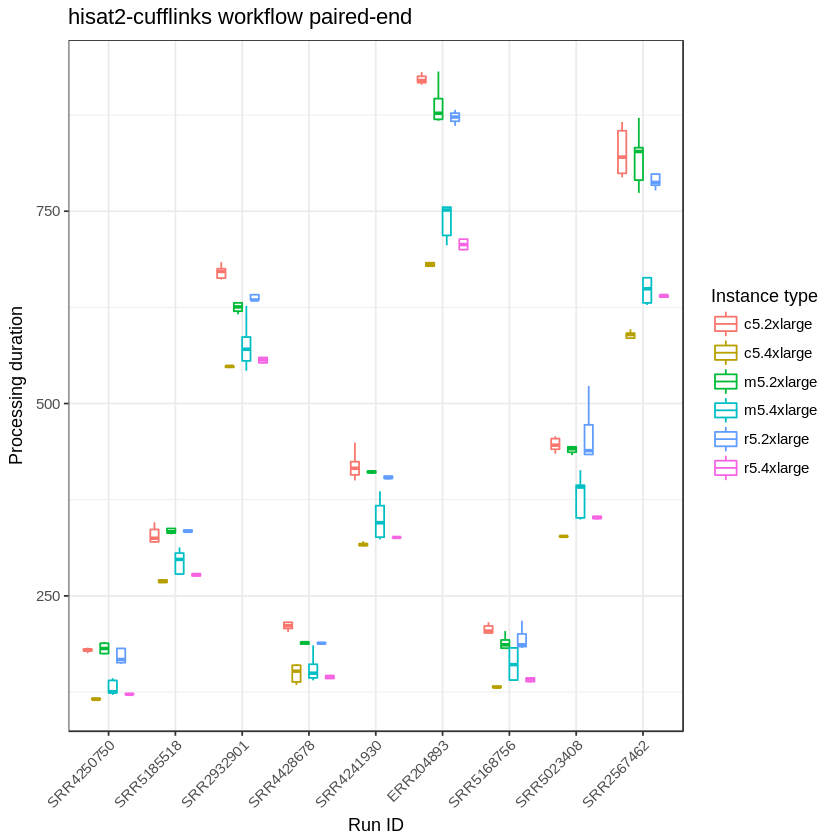

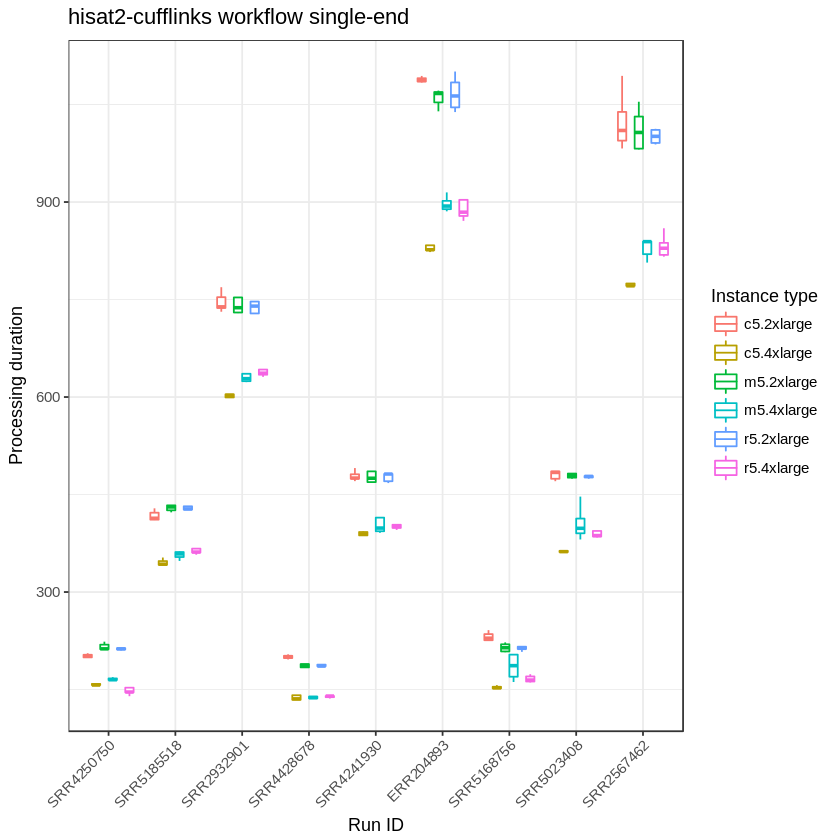

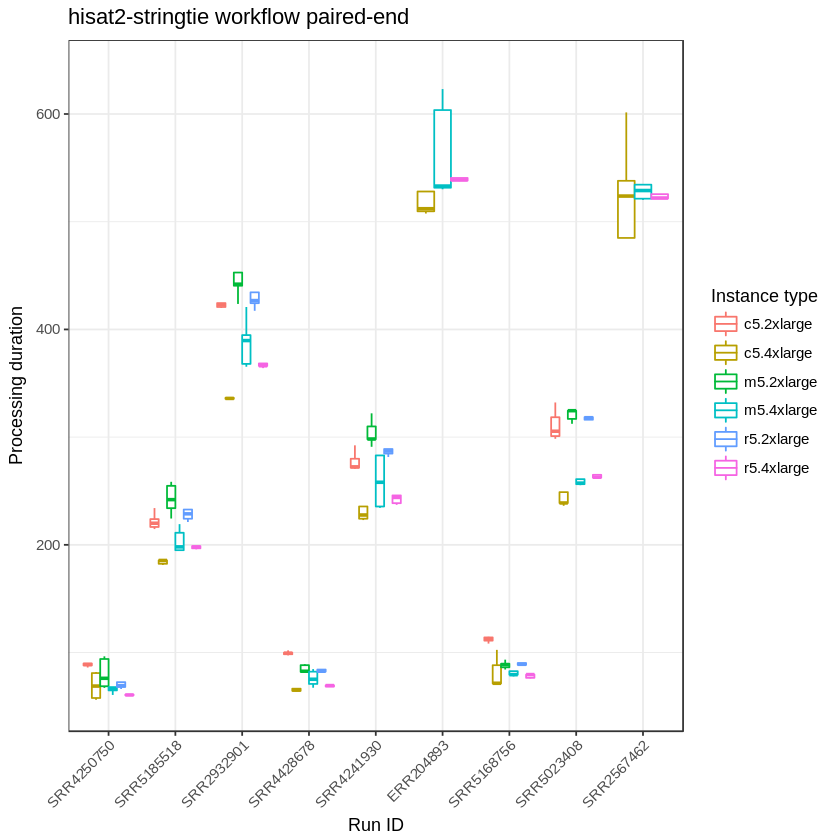

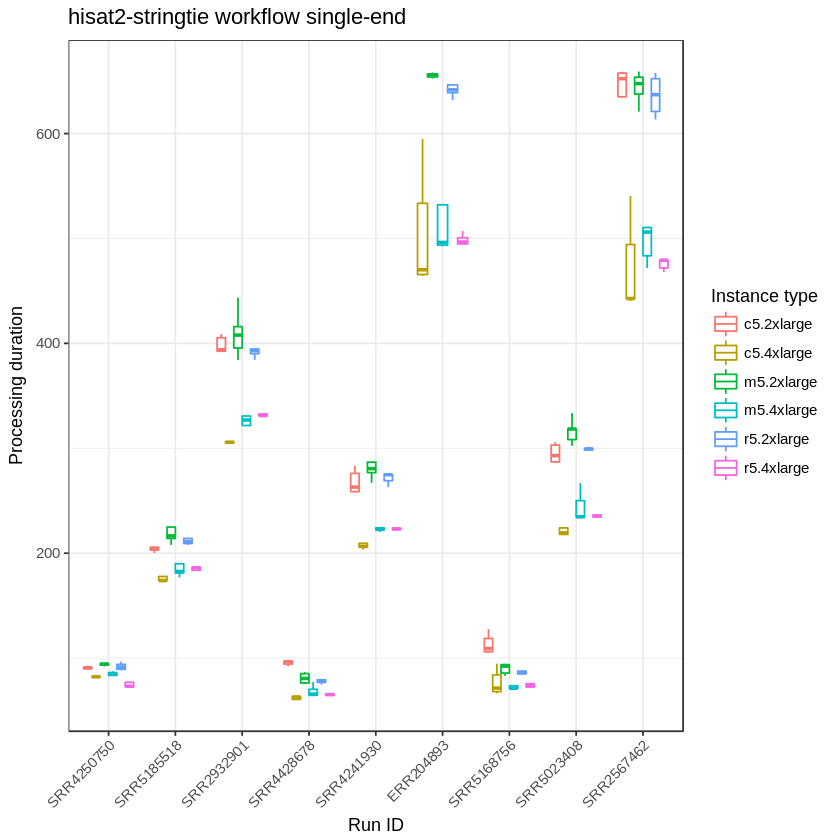

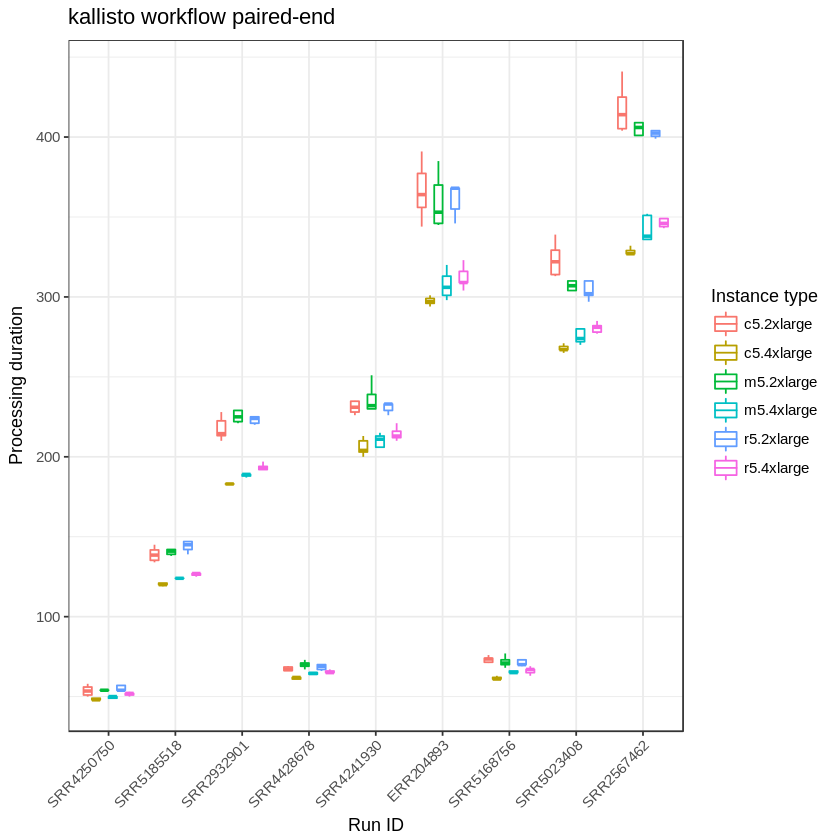

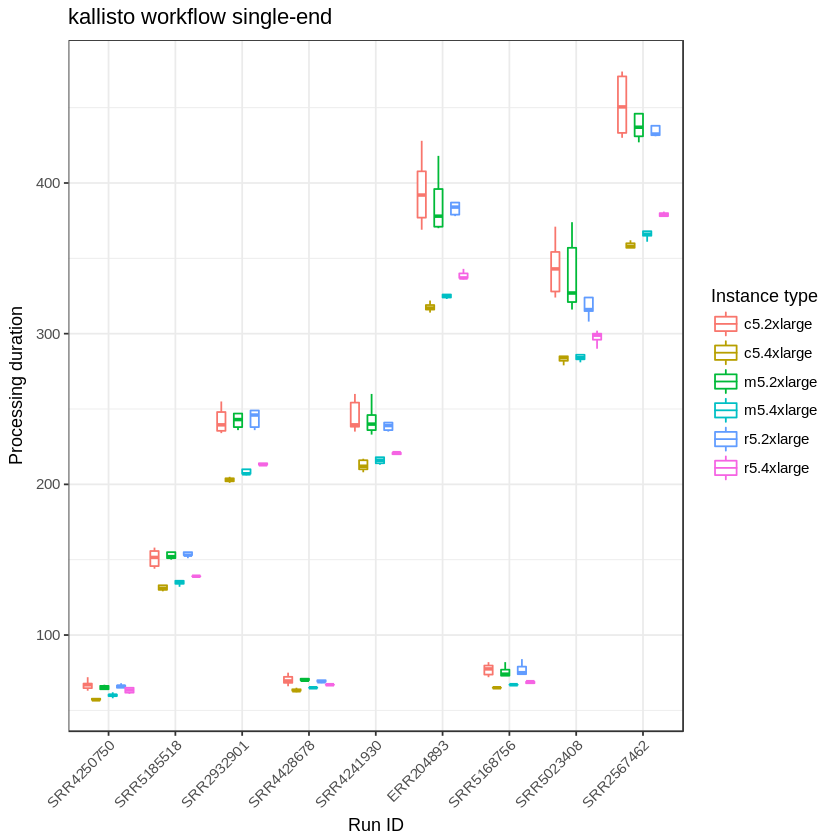

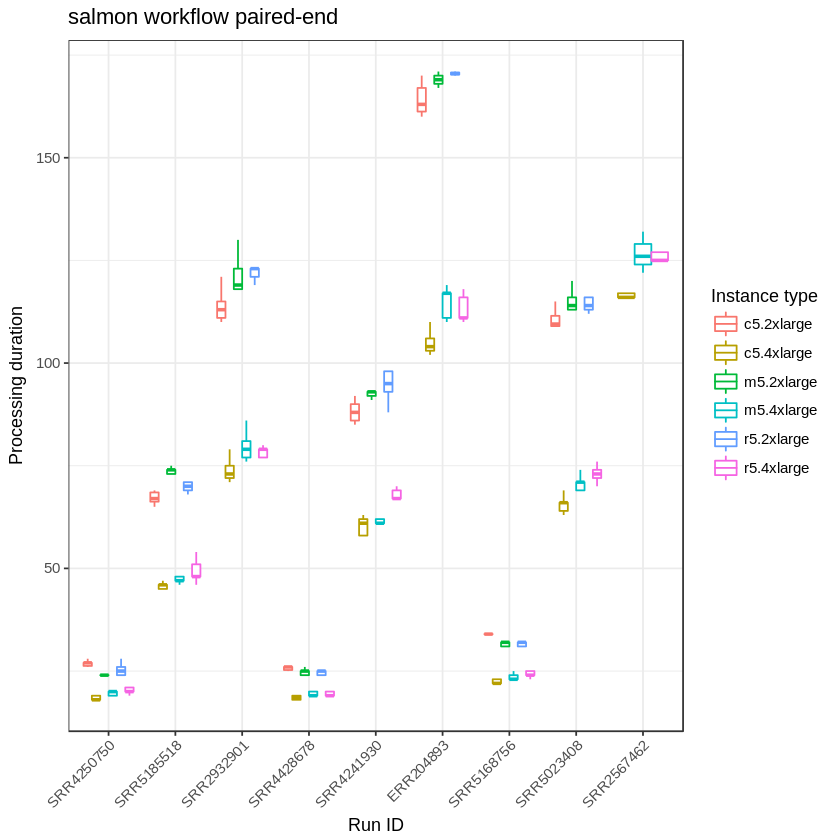

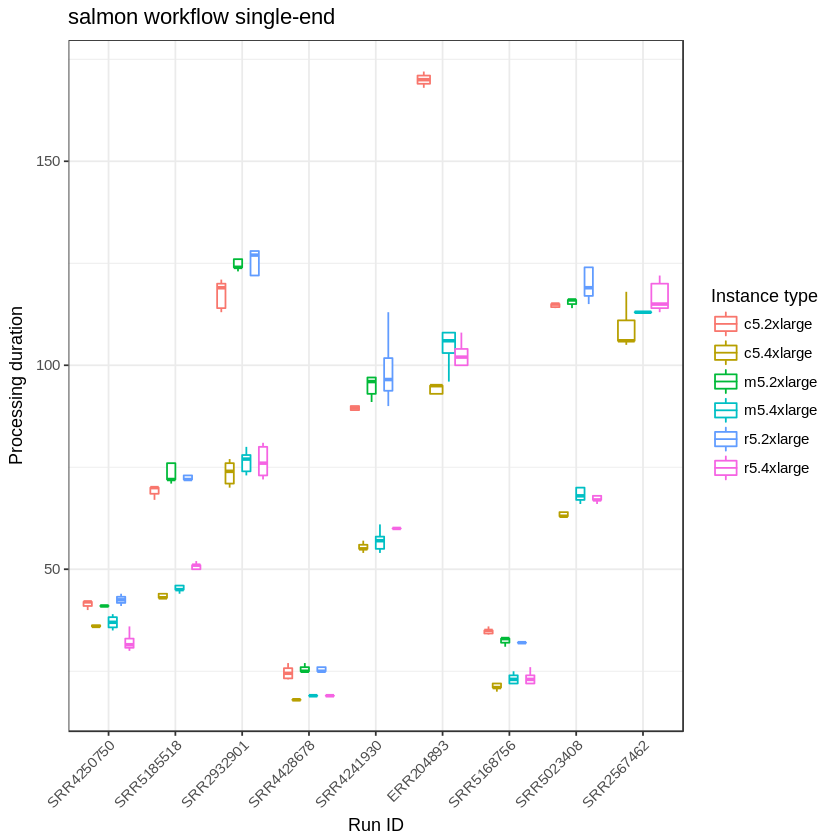

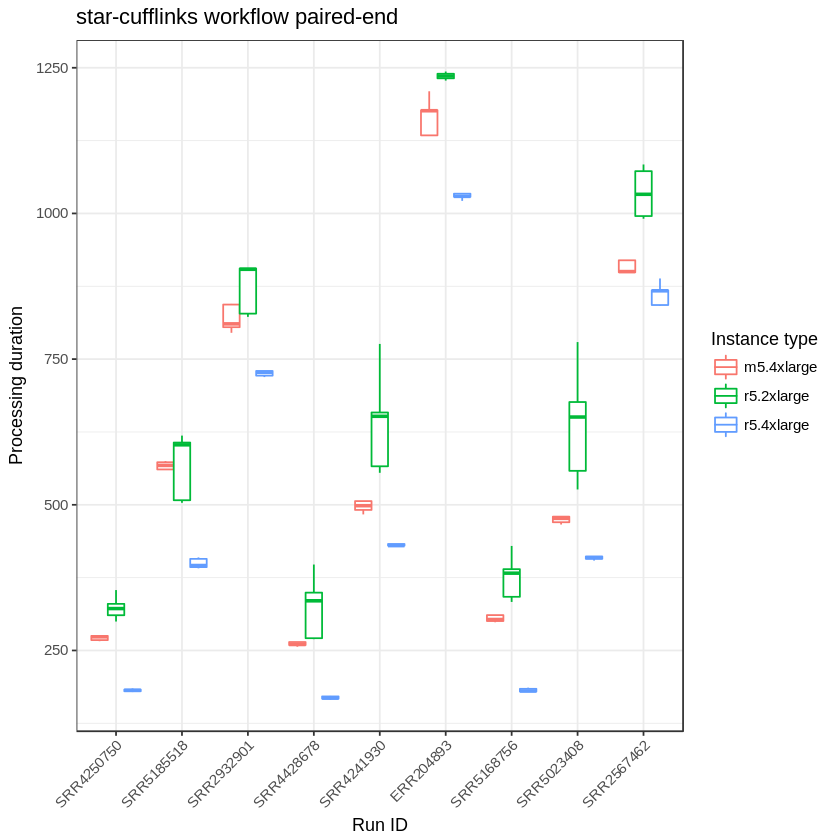

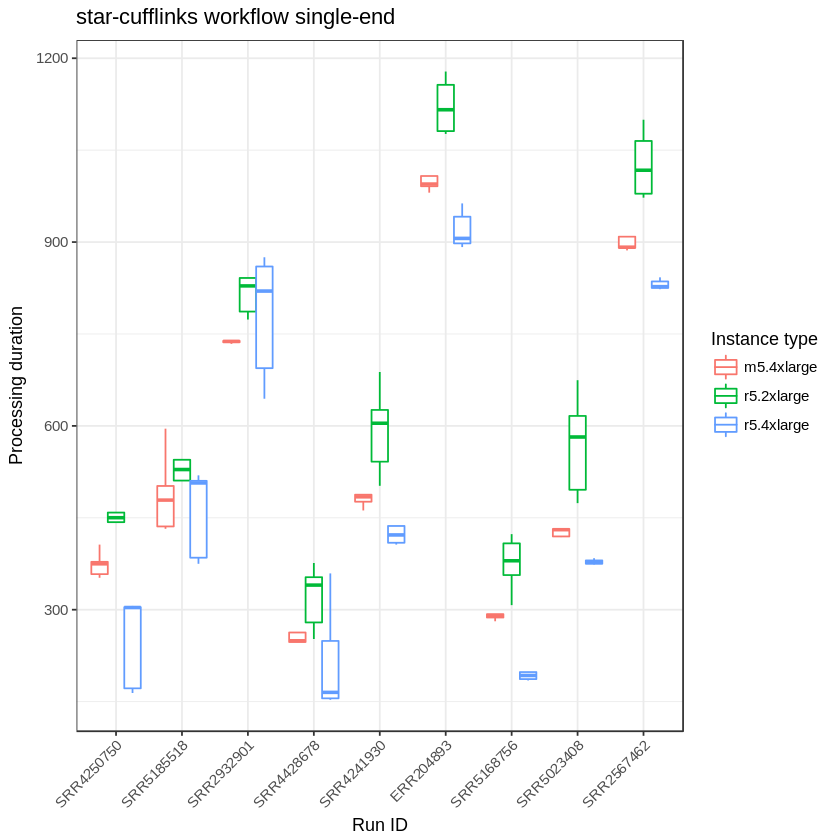

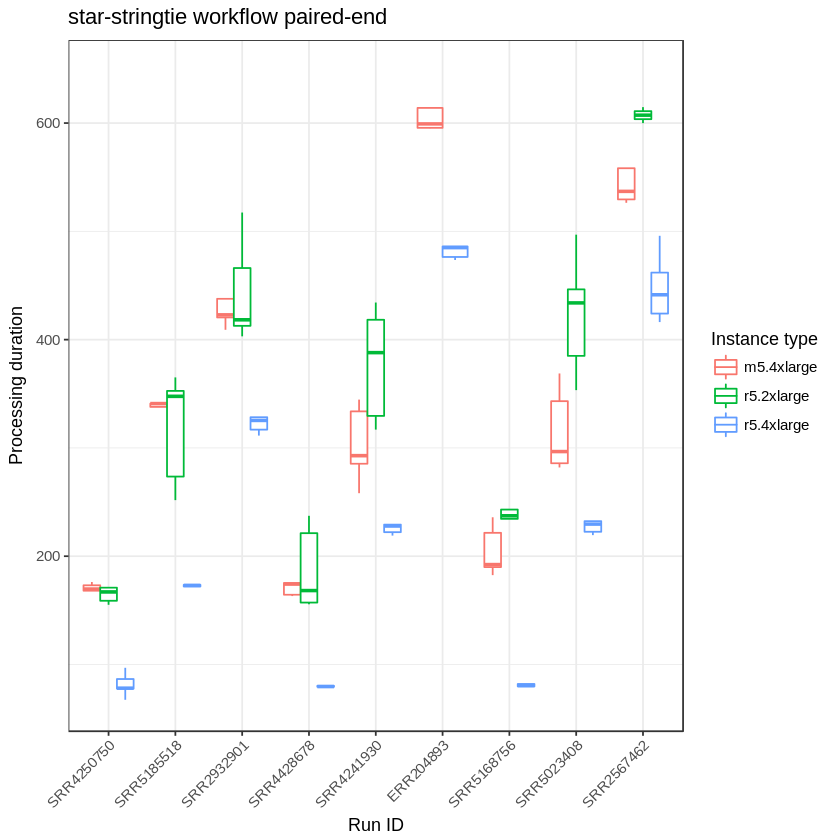

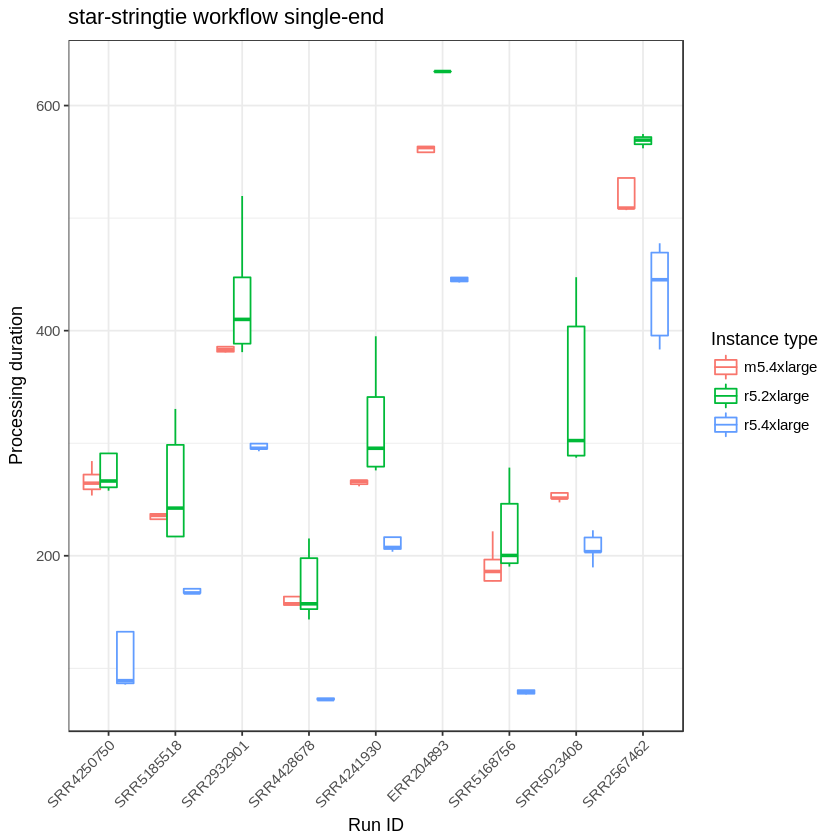

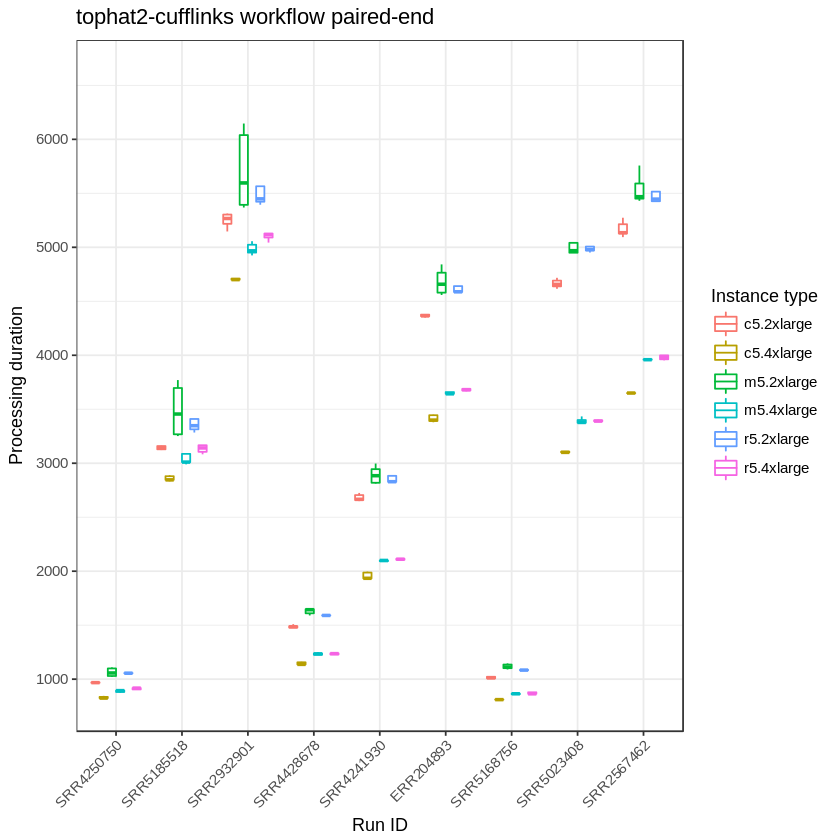

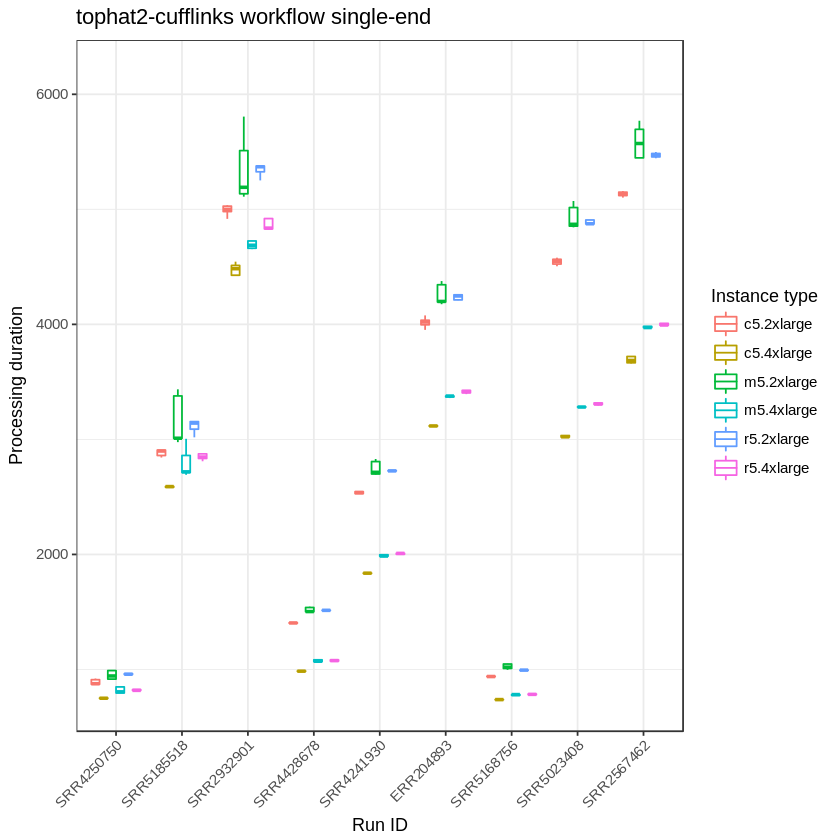

In [28]:
runs <- c("SRR4250750","SRR5185518","SRR2932901","SRR4428678","SRR4241930","ERR204893","SRR5168756","SRR5023408","SRR2567462")
workflow_name <- sort(unique(metrics$workflow_name))
for(wf_name in workflow_name) {
    d <- subset(metrics, workflow_name == wf_name)
    d <- subset(d, processing_duration < summary(d$processing_duration)[5]*1.5)
    
    p <- ggplot(d, aes(x=factor(run_id, levels=runs, ordered=TRUE), y=processing_duration, colour=factor(instance_type)))
    p <- p + geom_boxplot(outlier.shape=NA)
    p <- p + theme_bw() + theme(axis.text.x = element_text(angle = 45, hjust = 1))
    p <- p + labs(title=workflowName2PlotTitle(wf_name), x="Run ID", y="Processing duration", colour="Instance type")
    
    print(p)
}

#### Maximum CPU usage per sample

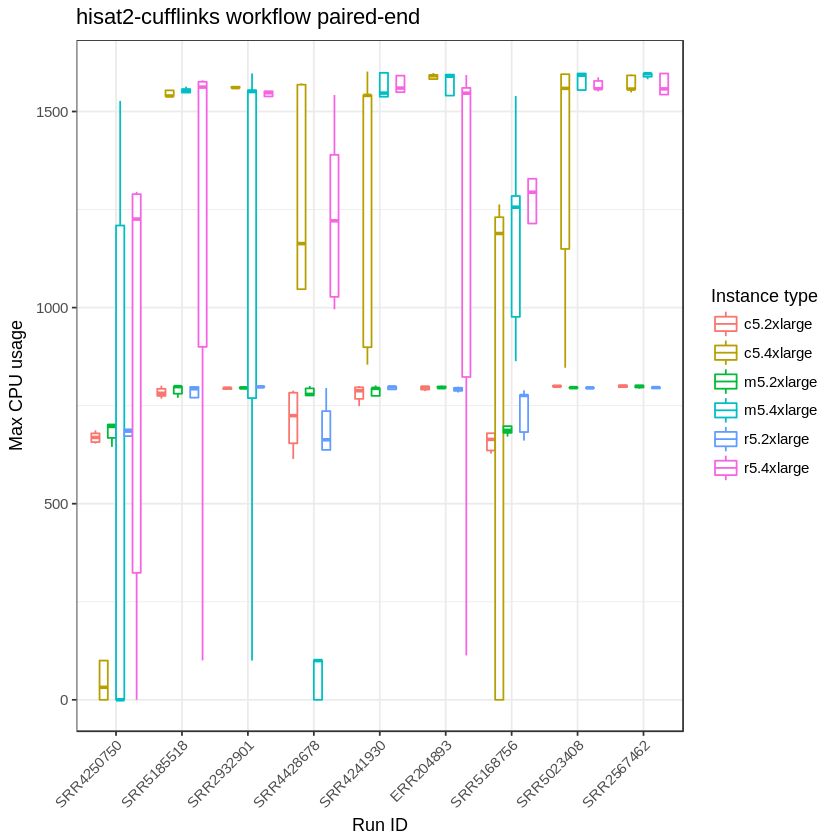

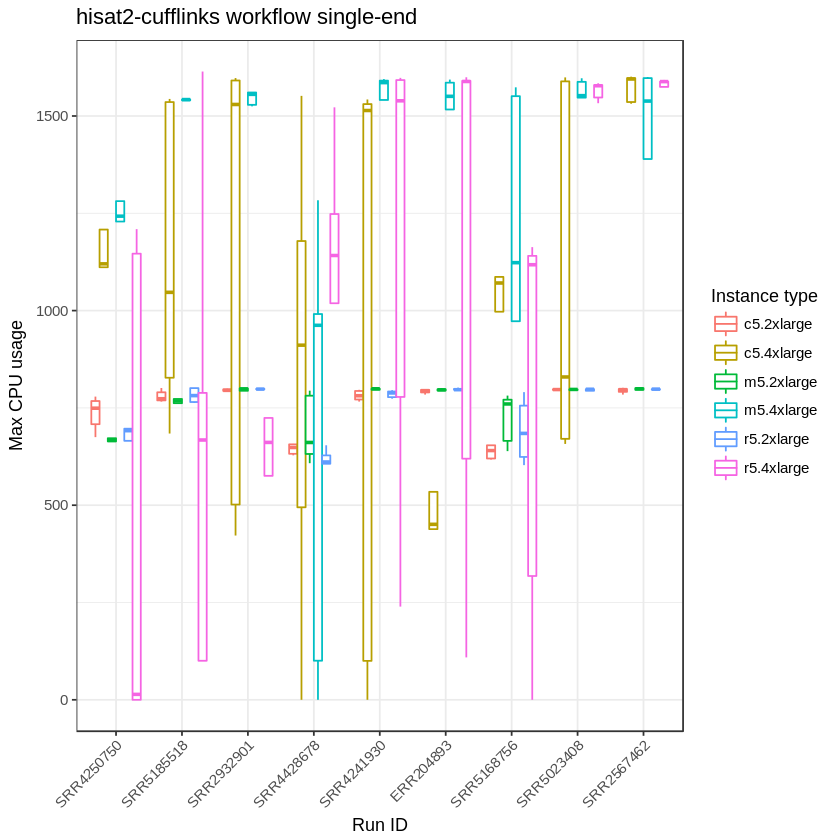

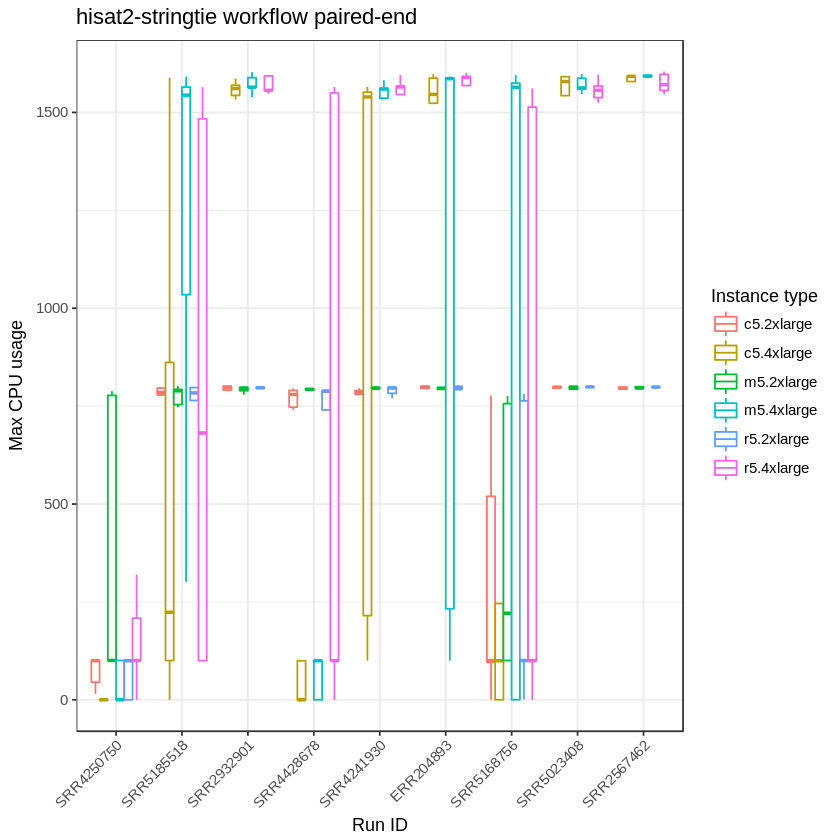

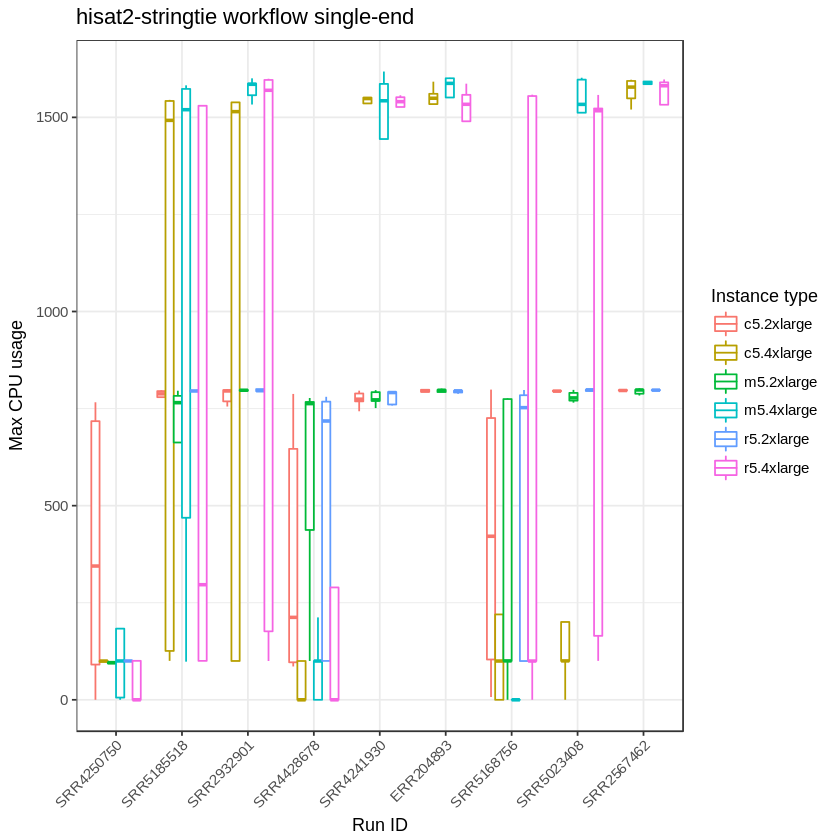

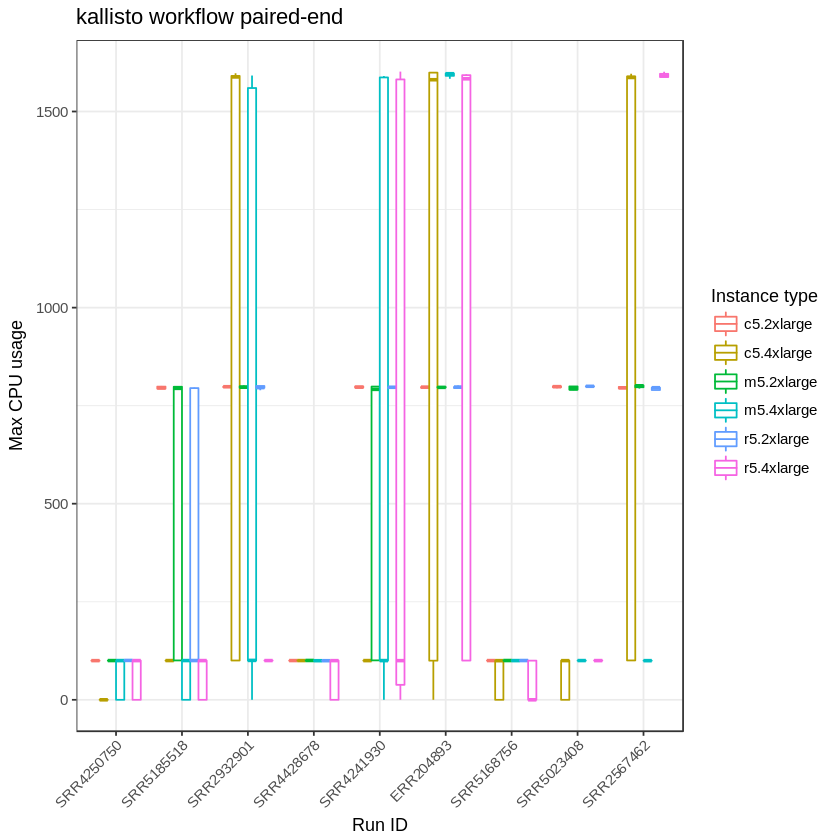

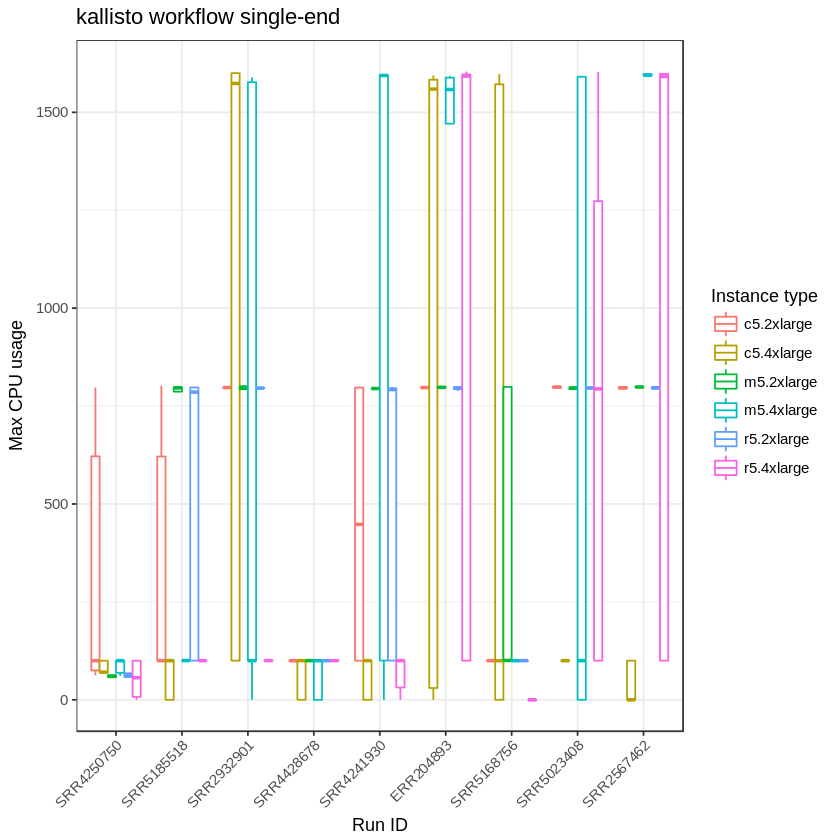

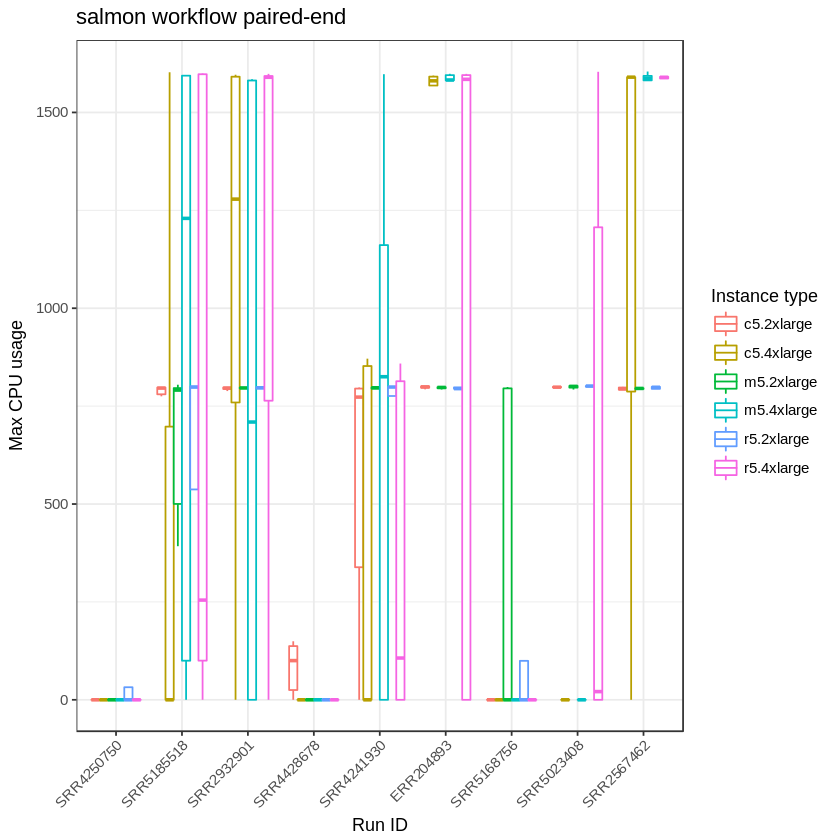

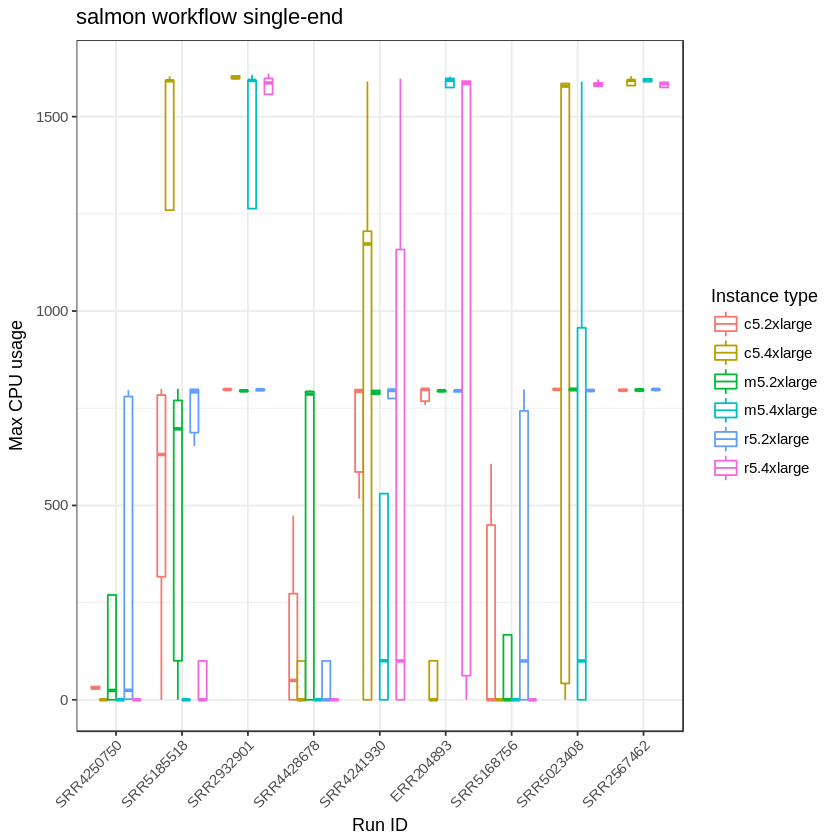

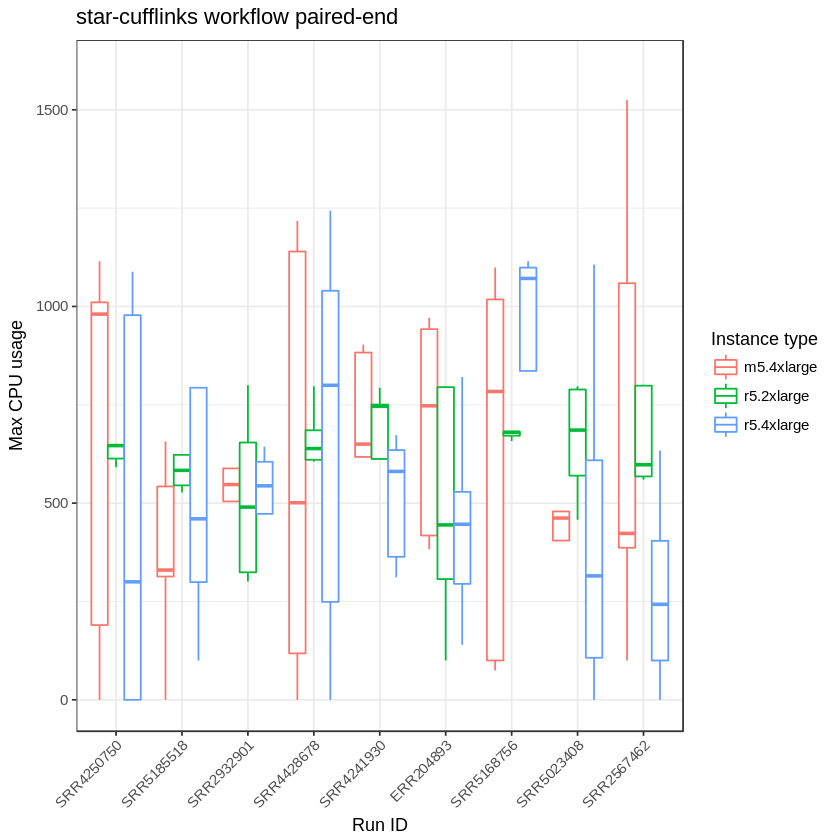

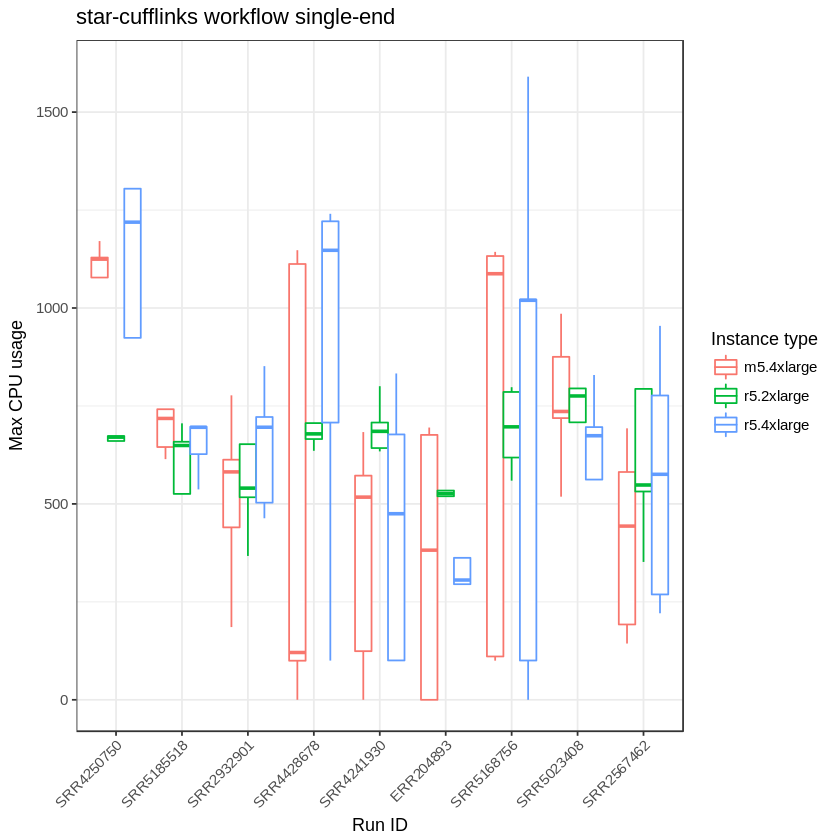

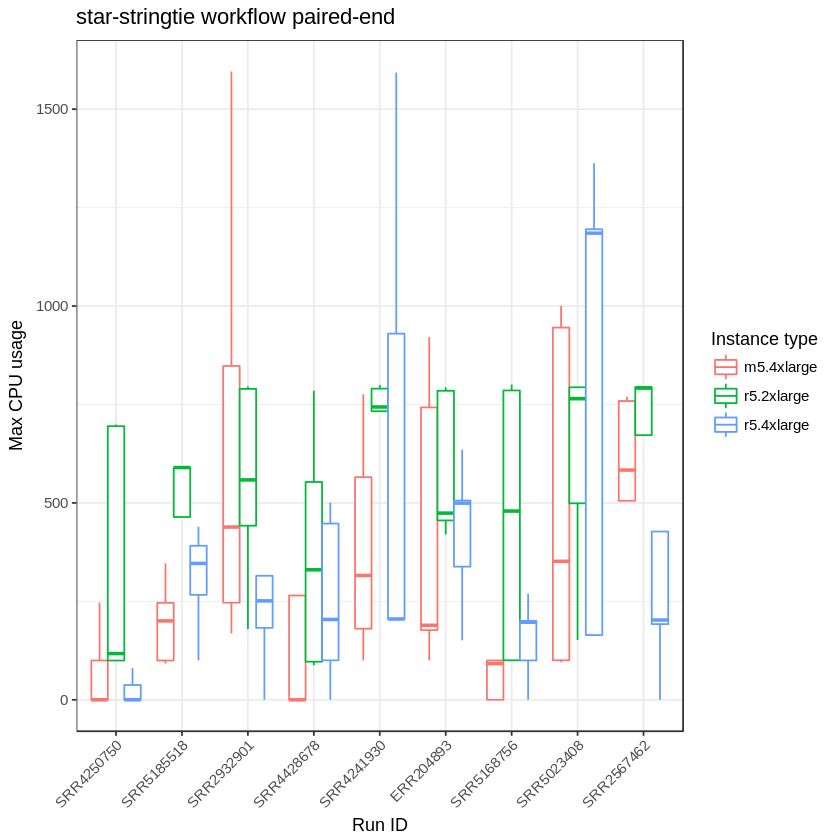

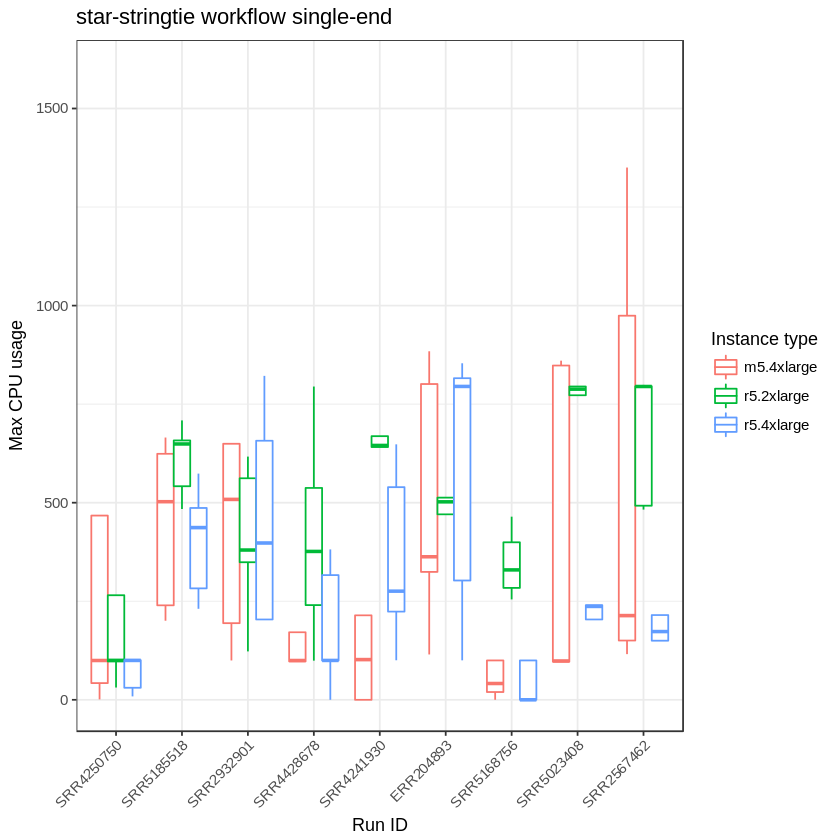

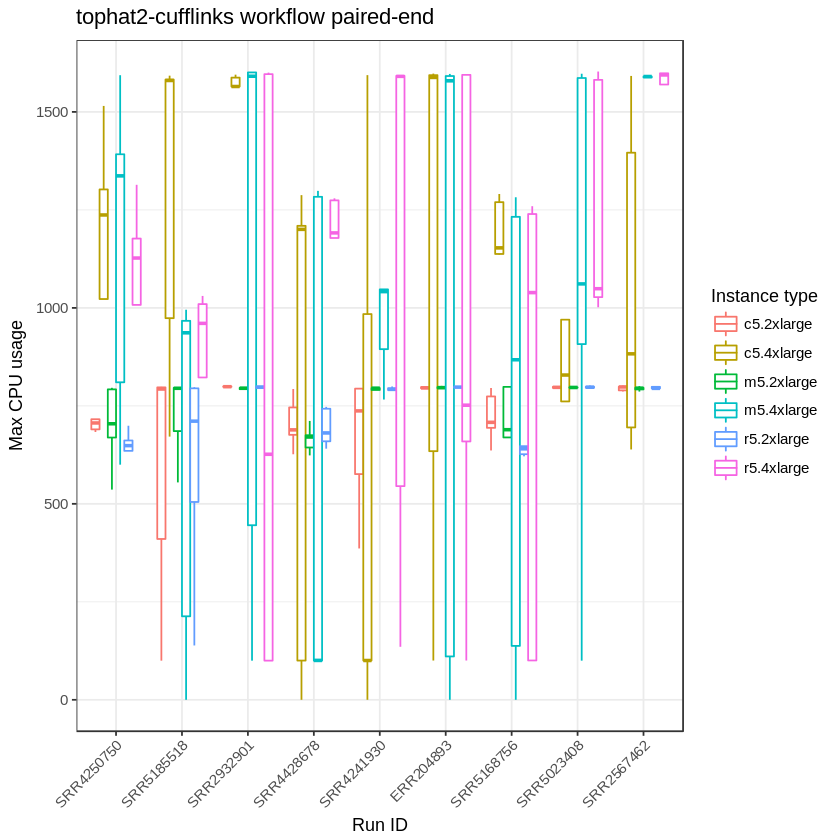

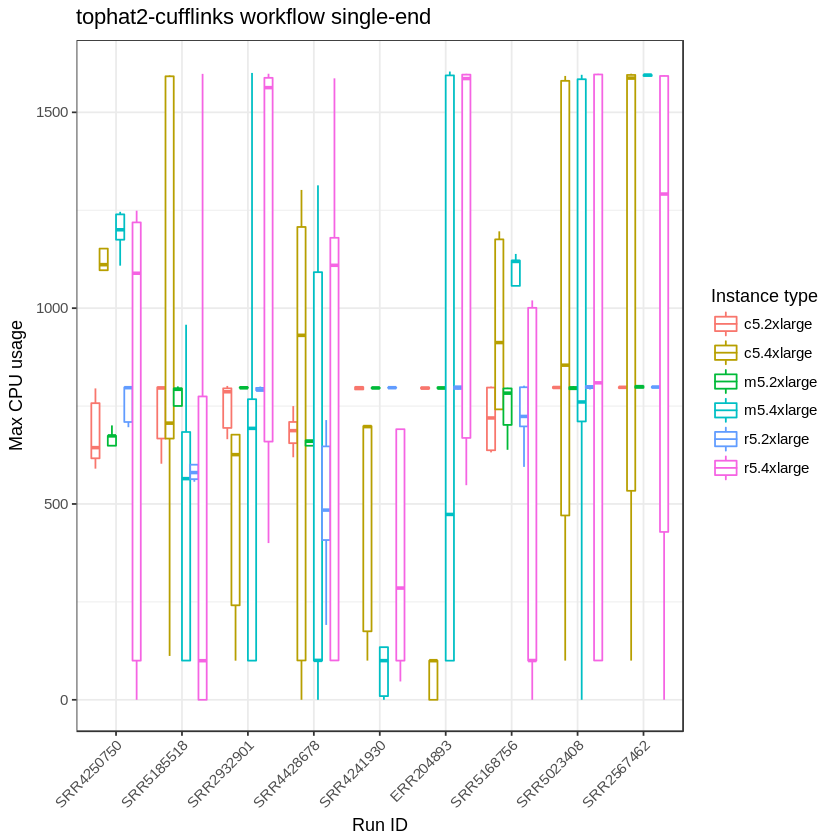

In [29]:
runs <- c("SRR4250750","SRR5185518","SRR2932901","SRR4428678","SRR4241930","ERR204893","SRR5168756","SRR5023408","SRR2567462")
workflow_name <- sort(unique(metrics$workflow_name))
for(wf_name in workflow_name) {
    d <- subset(metrics, workflow_name == wf_name)
    #d <- subset(d, processing_duration < summary(d$processing_duration)[5]*1.5)
    
    p <- ggplot(d, aes(x=factor(run_id, levels=runs, ordered=TRUE), y=cpu, colour=factor(instance_type)))
    p <- p + geom_boxplot(outlier.shape=NA)
    p <- p + theme_bw() + theme(axis.text.x = element_text(angle = 45, hjust = 1))
    p <- p + labs(title=workflowName2PlotTitle(wf_name), x="Run ID", y="Max CPU usage", colour="Instance type")
    
    print(p)
}

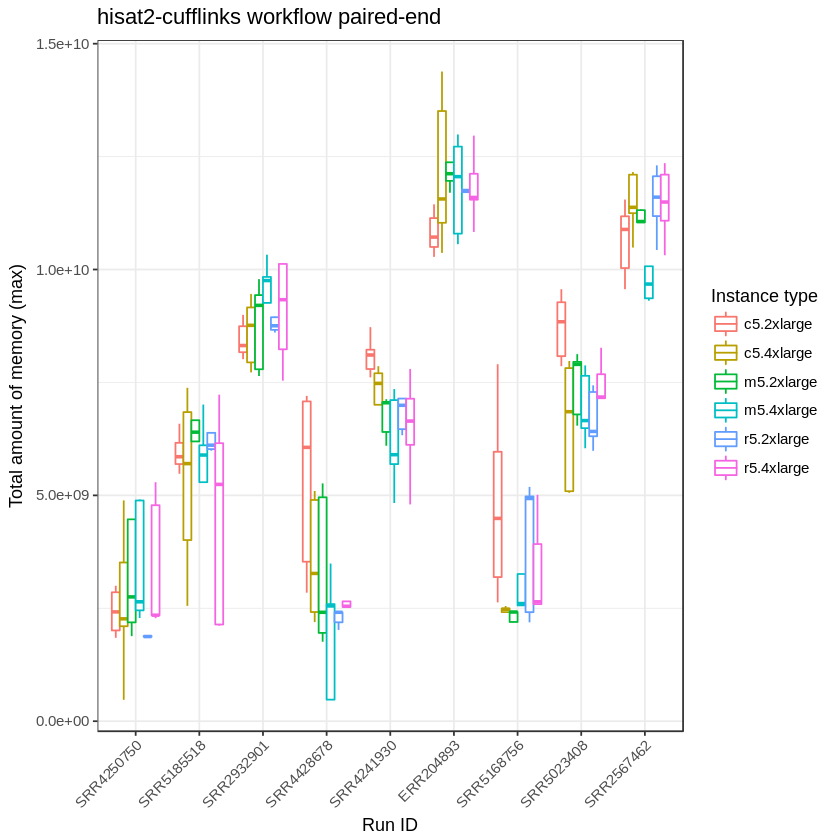

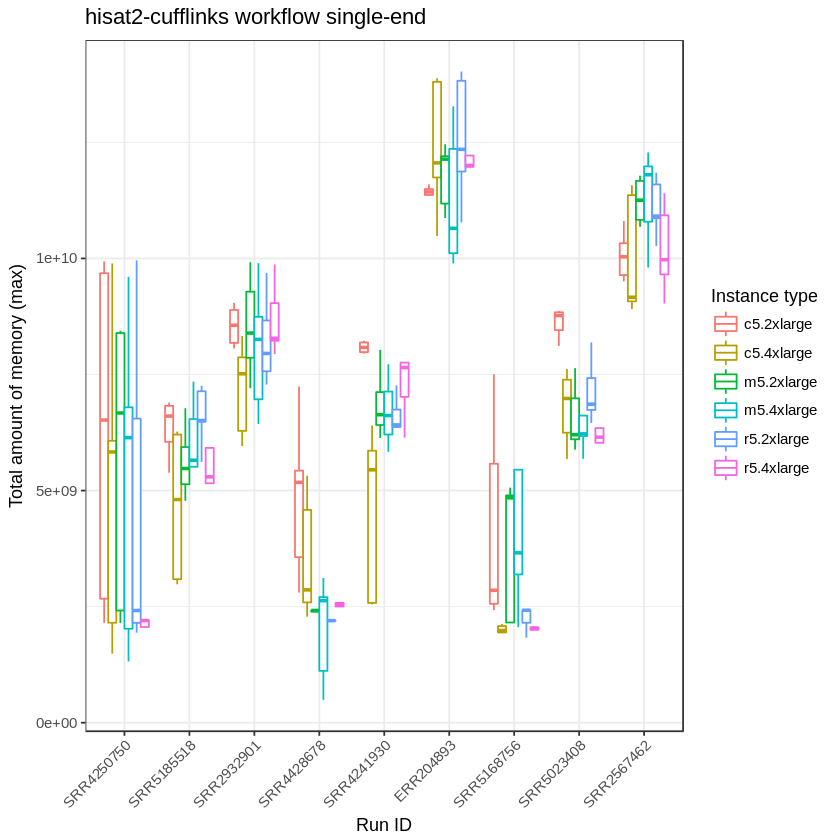

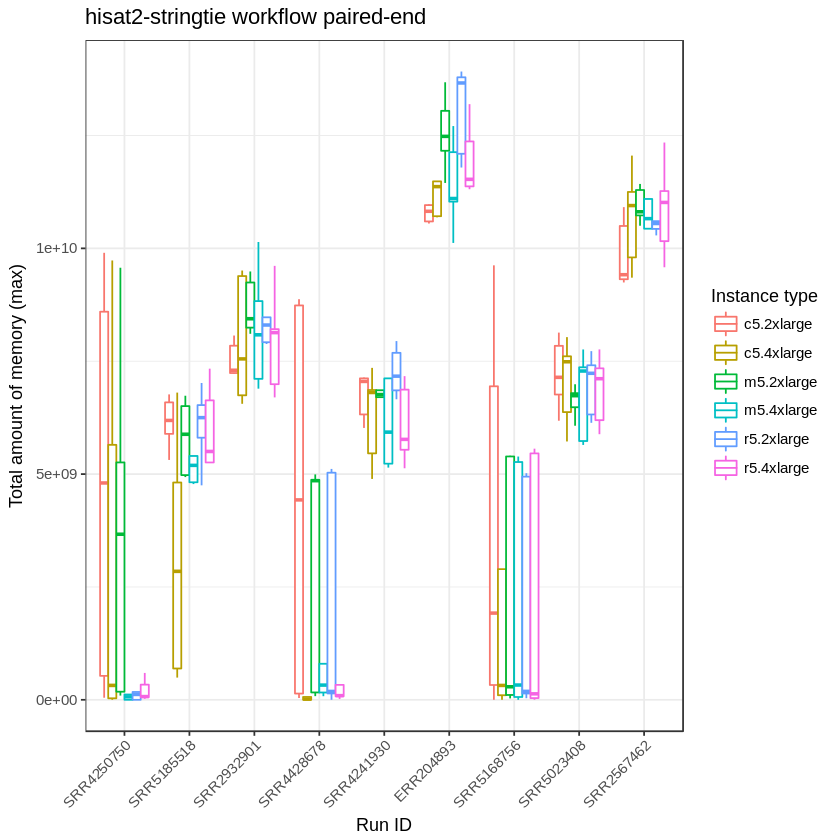

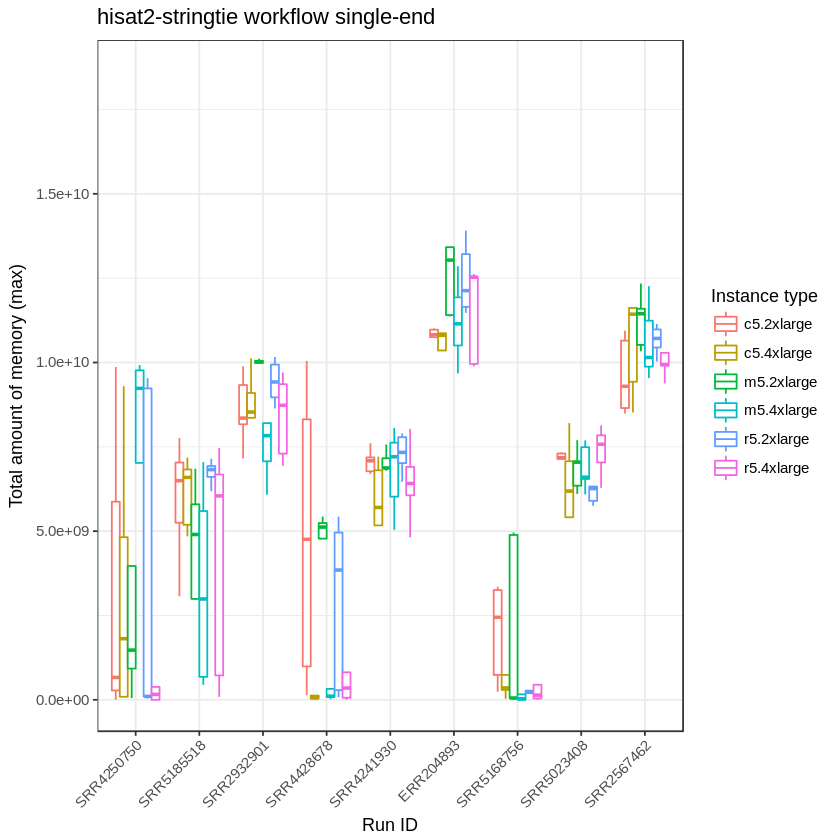

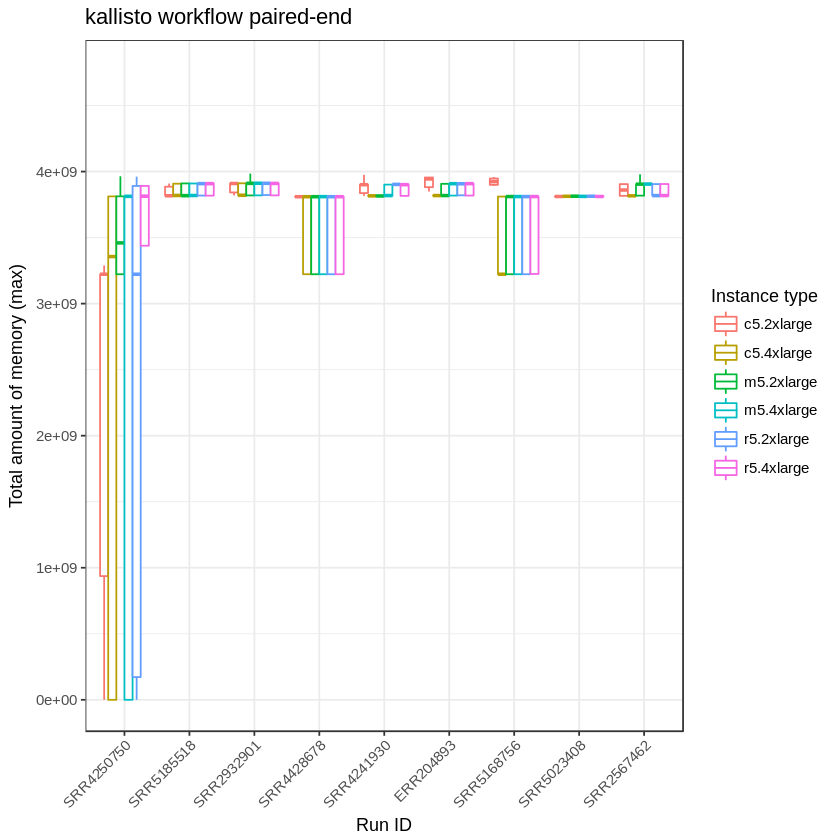

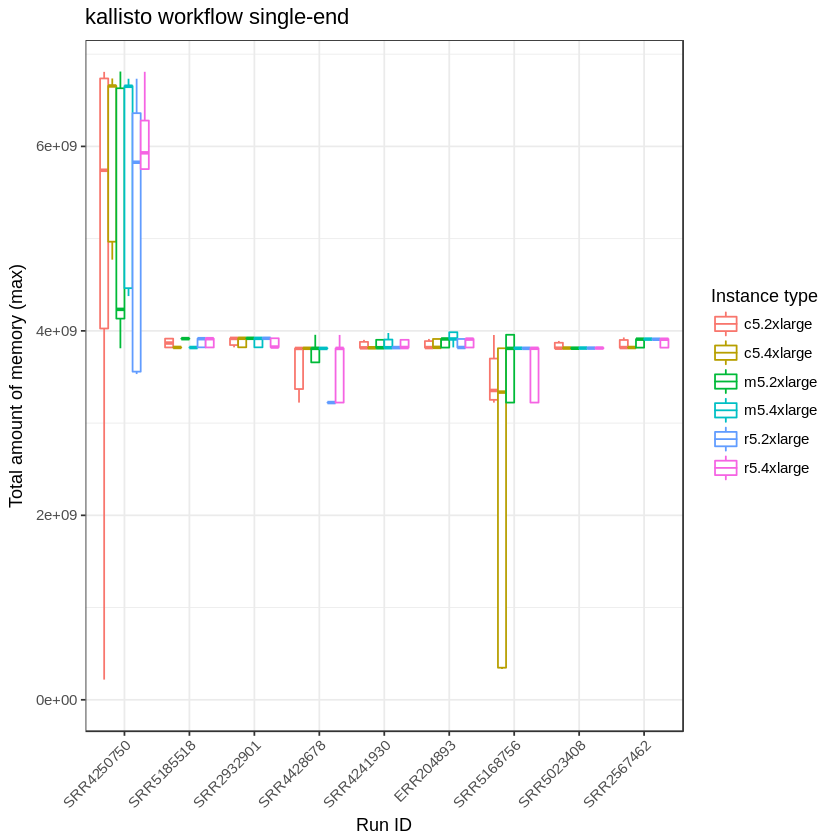

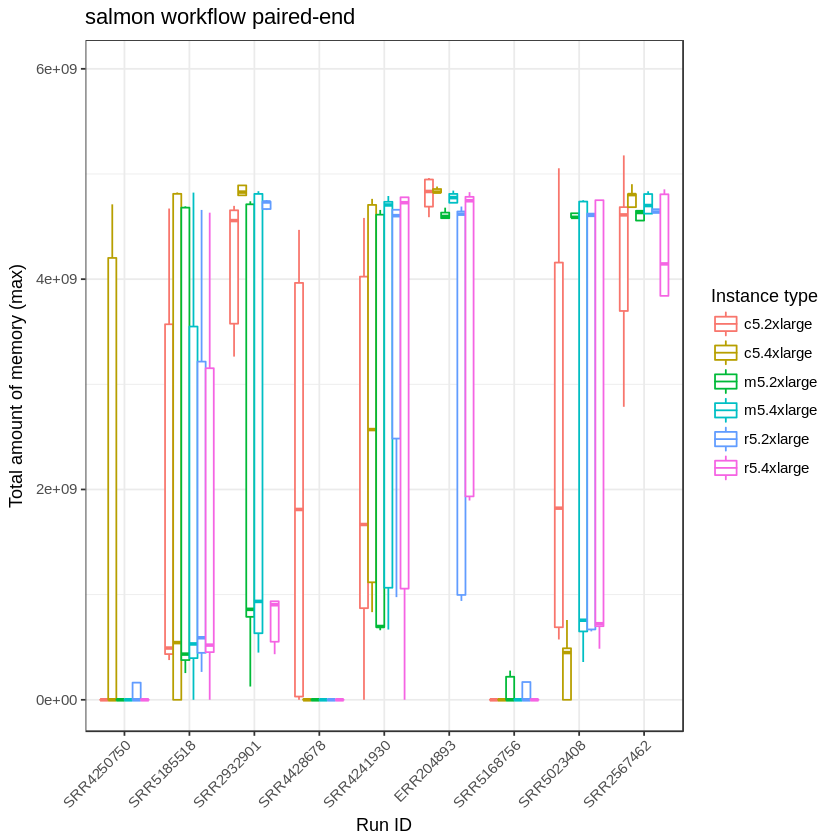

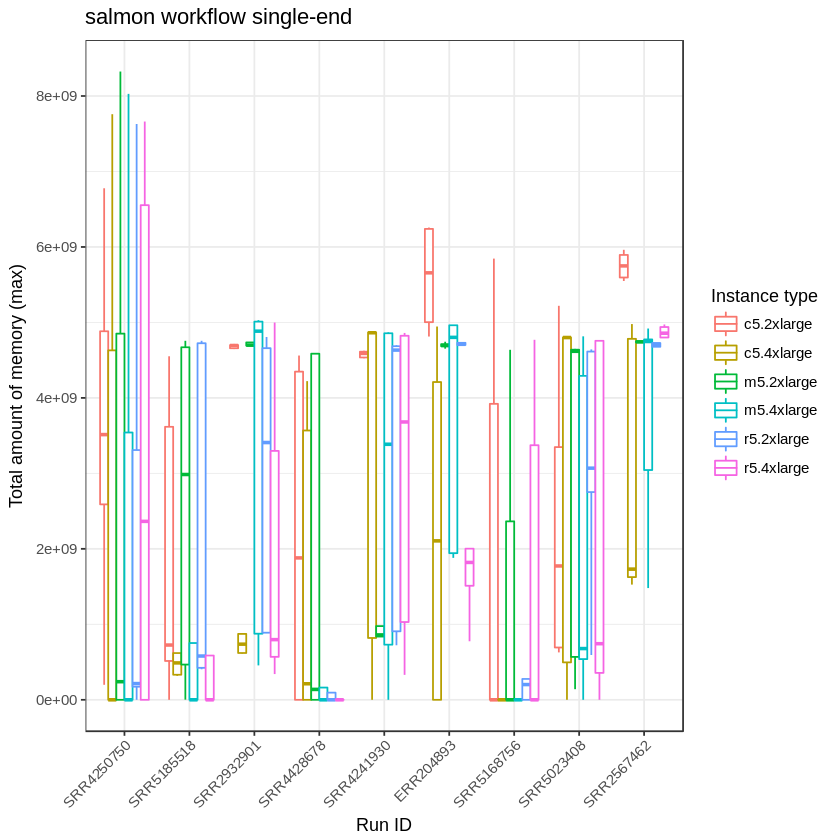

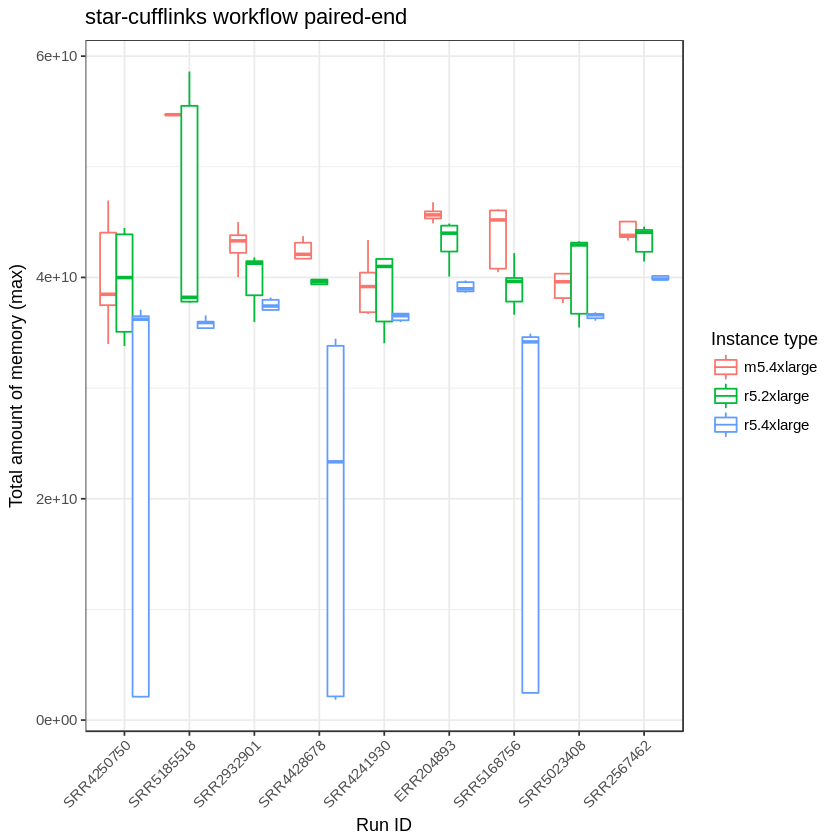

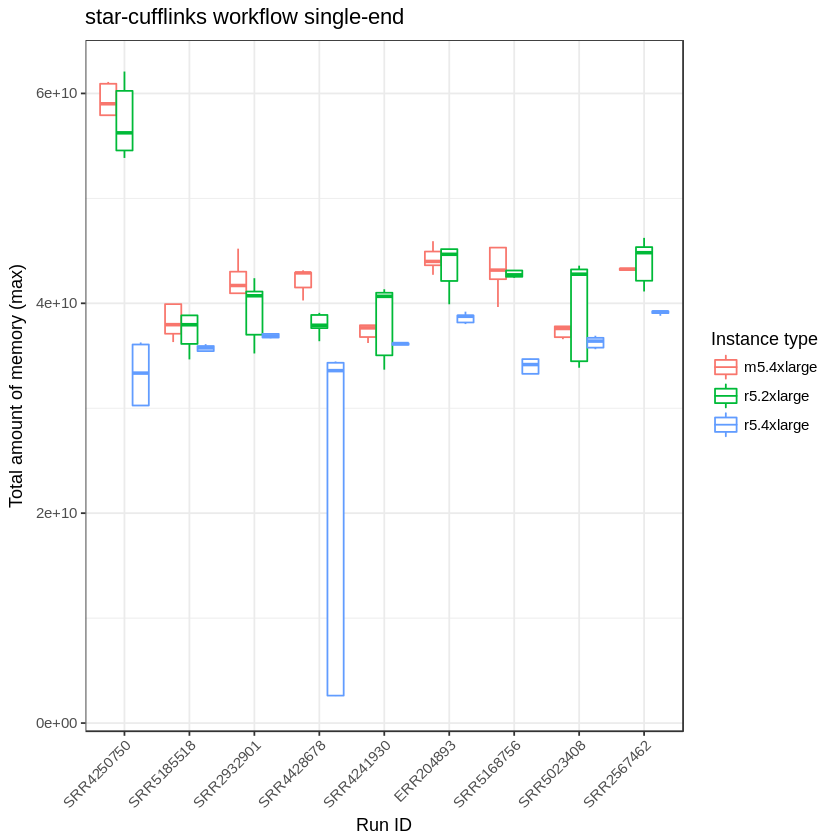

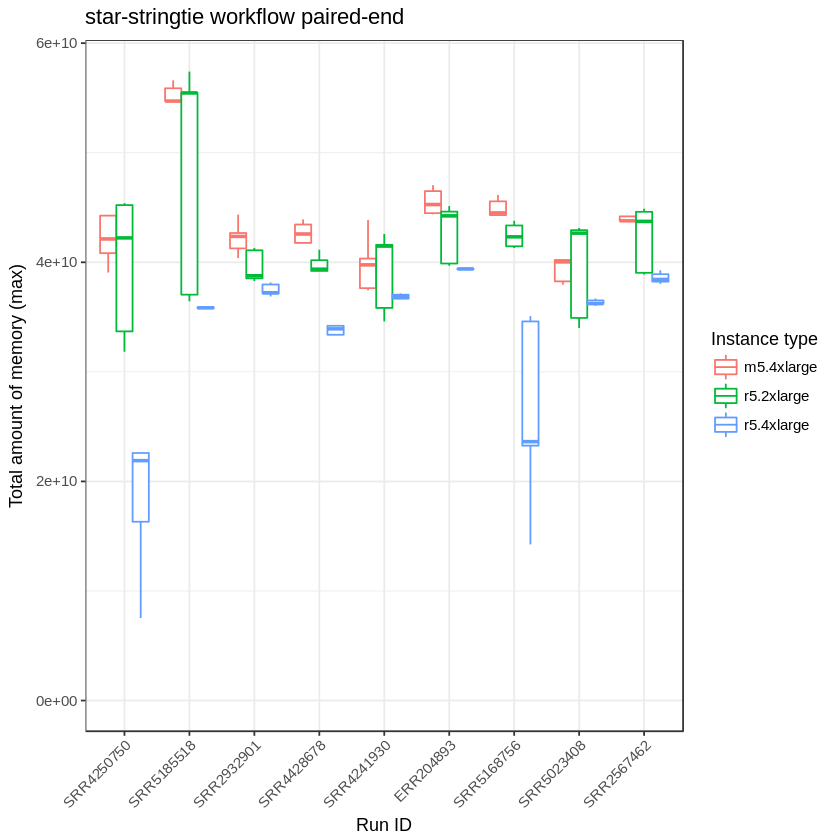

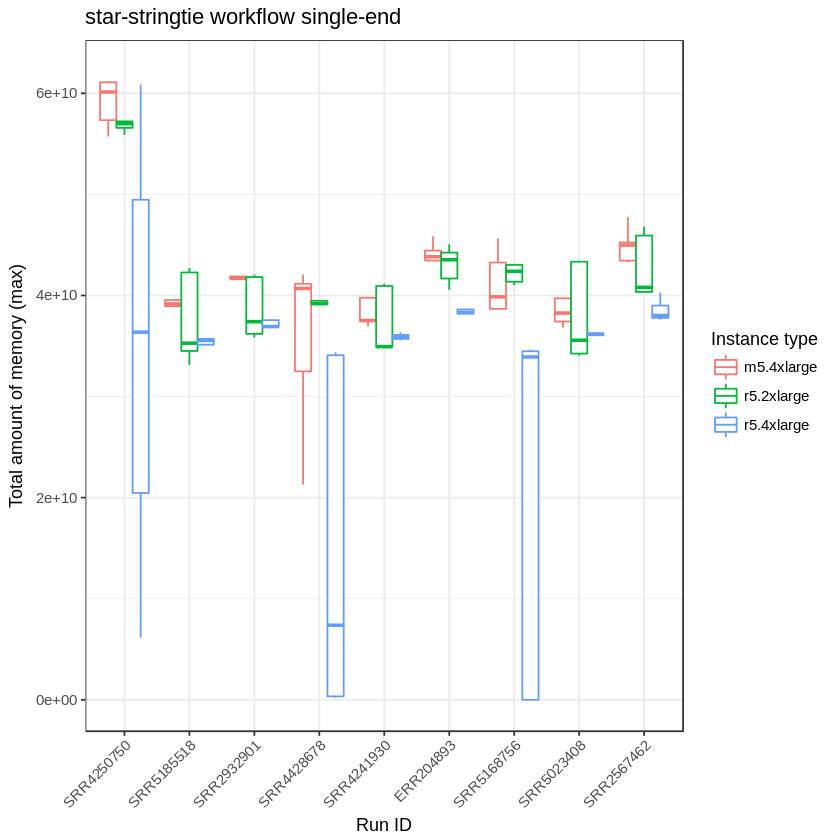

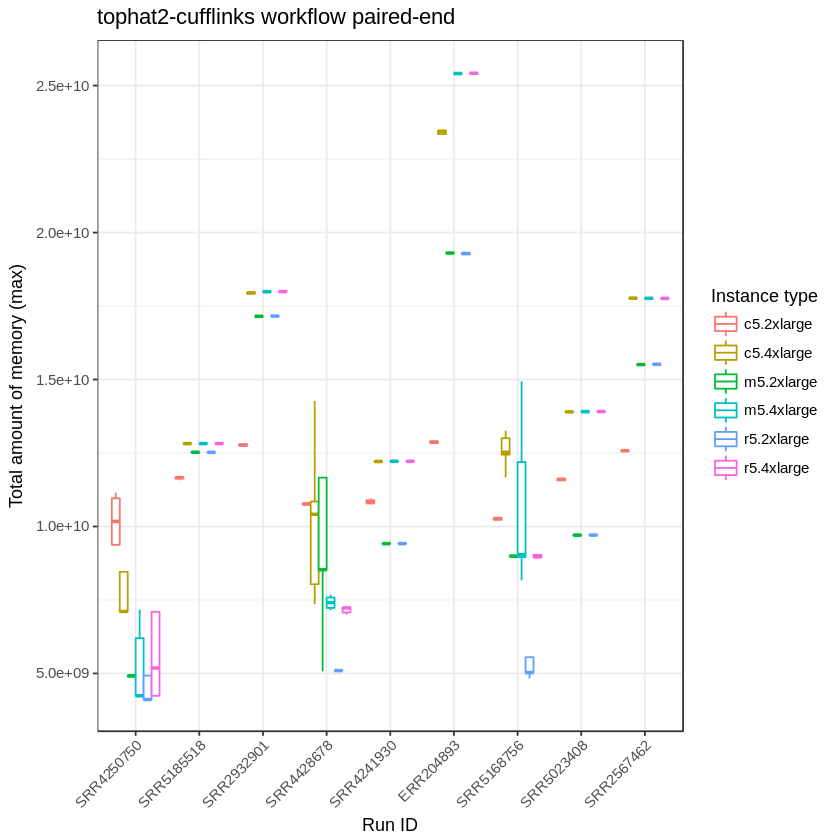

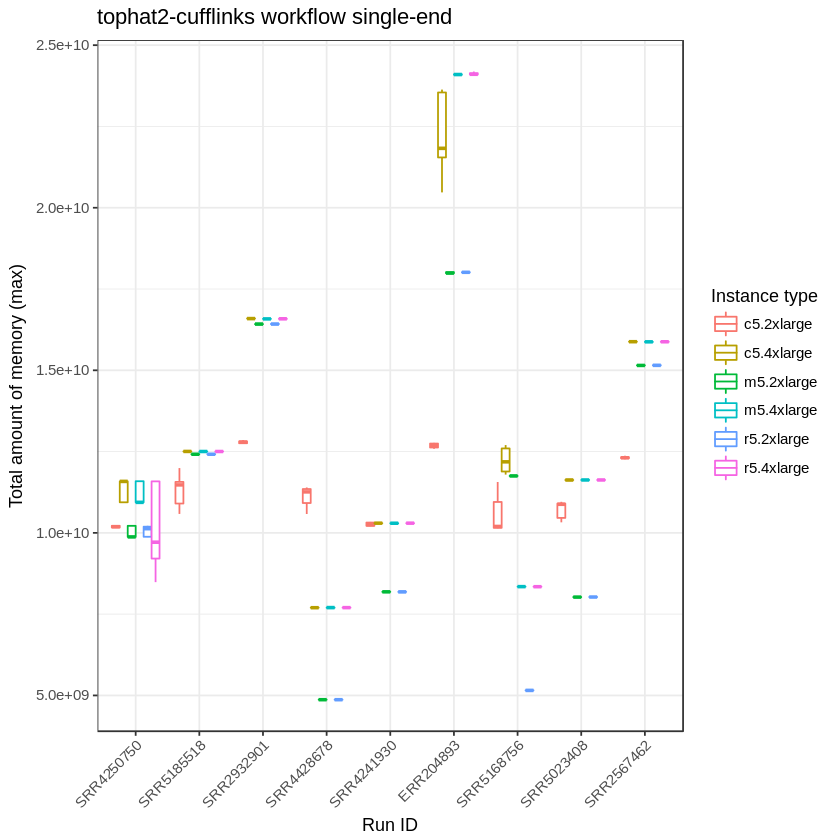

In [30]:
runs <- c("SRR4250750","SRR5185518","SRR2932901","SRR4428678","SRR4241930","ERR204893","SRR5168756","SRR5023408","SRR2567462")
workflow_name <- sort(unique(metrics$workflow_name))
for(wf_name in workflow_name) {
    d <- subset(metrics, workflow_name == wf_name)
    #d <- subset(d, processing_duration < summary(d$processing_duration)[5]*1.5)
    
    p <- ggplot(d, aes(x=factor(run_id, levels=runs, ordered=TRUE), y=mem, colour=factor(instance_type)))
    p <- p + geom_boxplot(outlier.shape=NA)
    p <- p + theme_bw() + theme(axis.text.x = element_text(angle = 45, hjust = 1))
    p <- p + labs(title=workflowName2PlotTitle(wf_name), x="Run ID", y="Total amount of memory (max)", colour="Instance type")
    
    print(p)
}

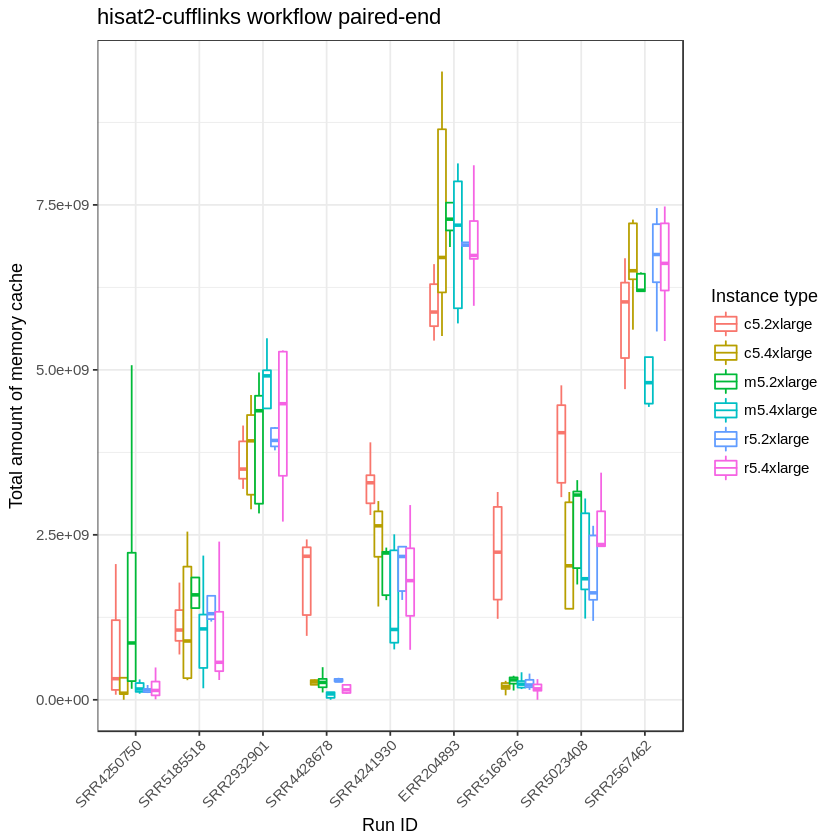

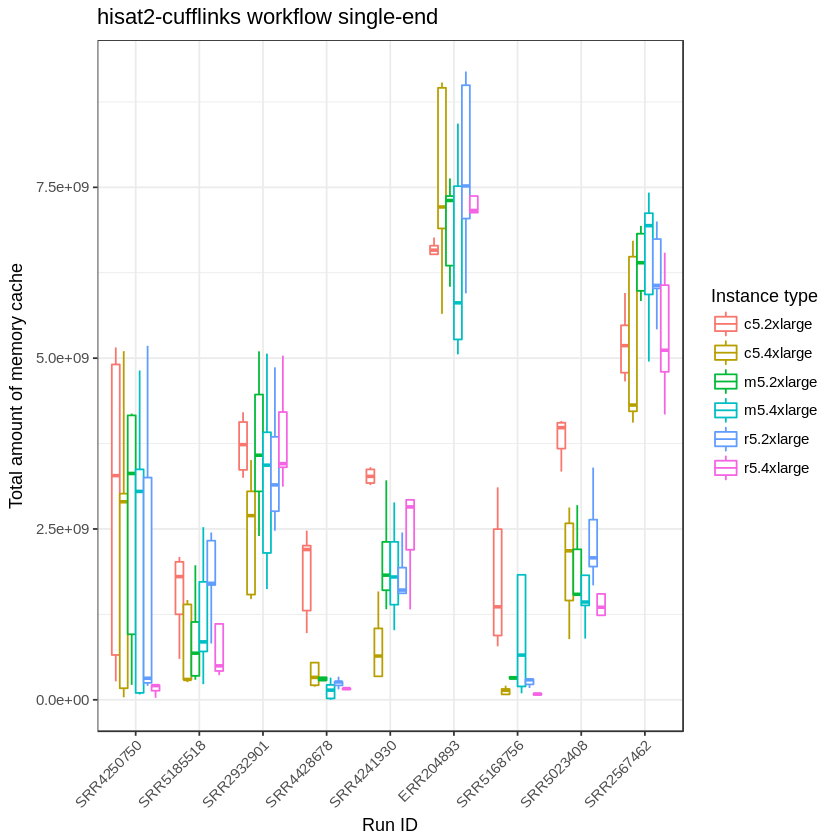

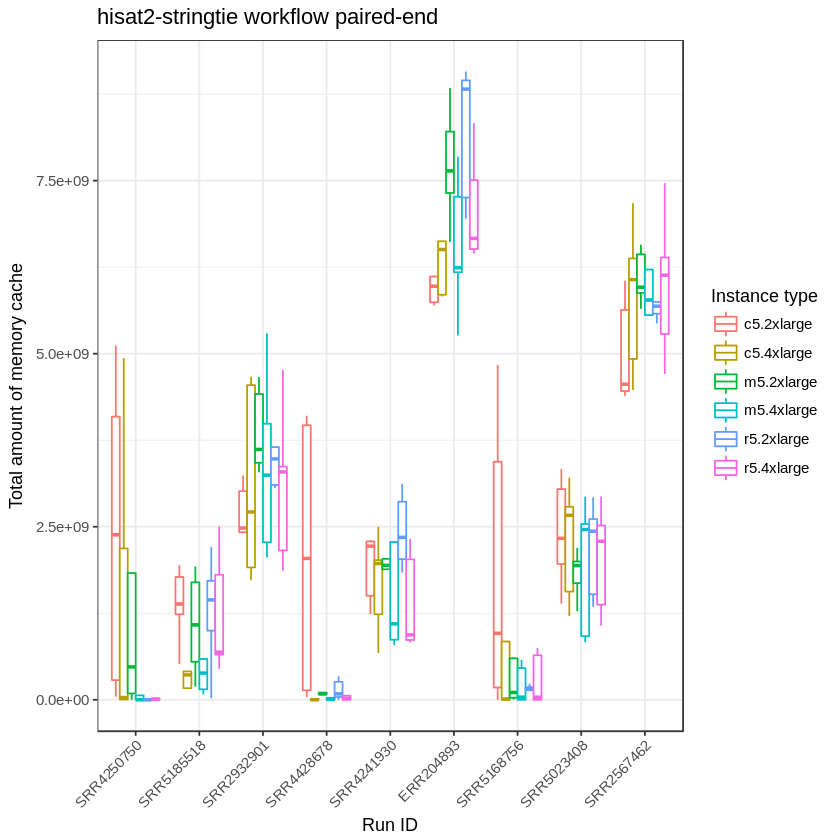

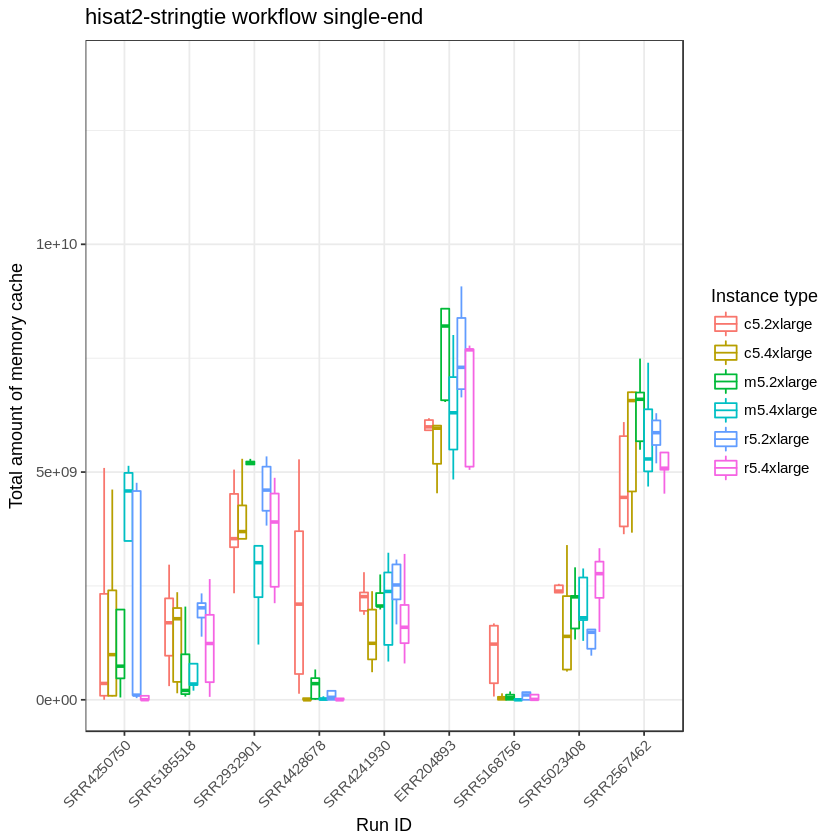

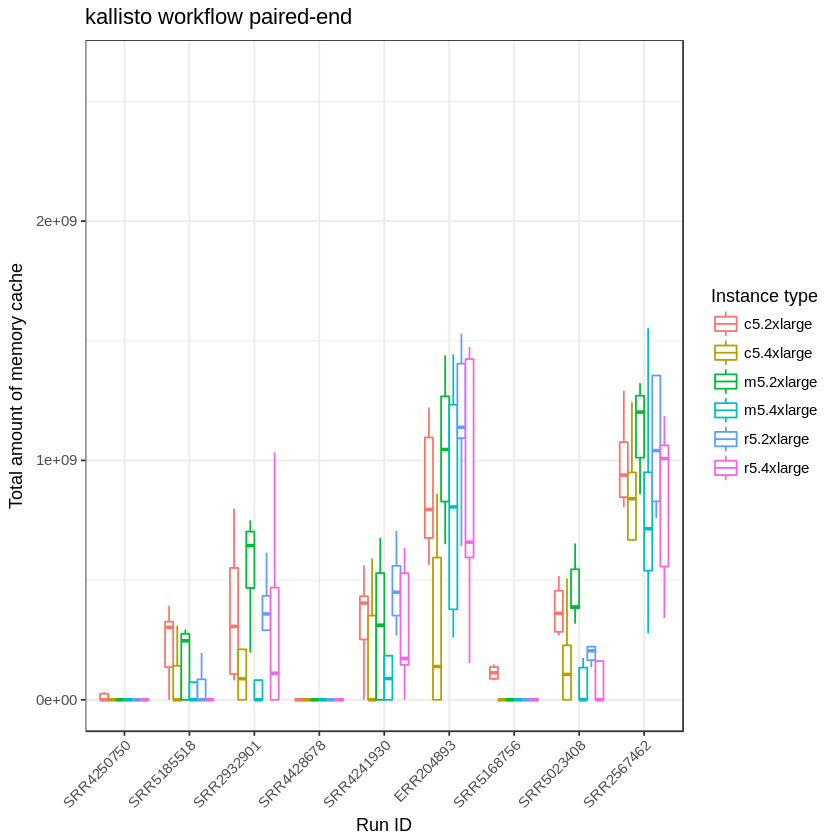

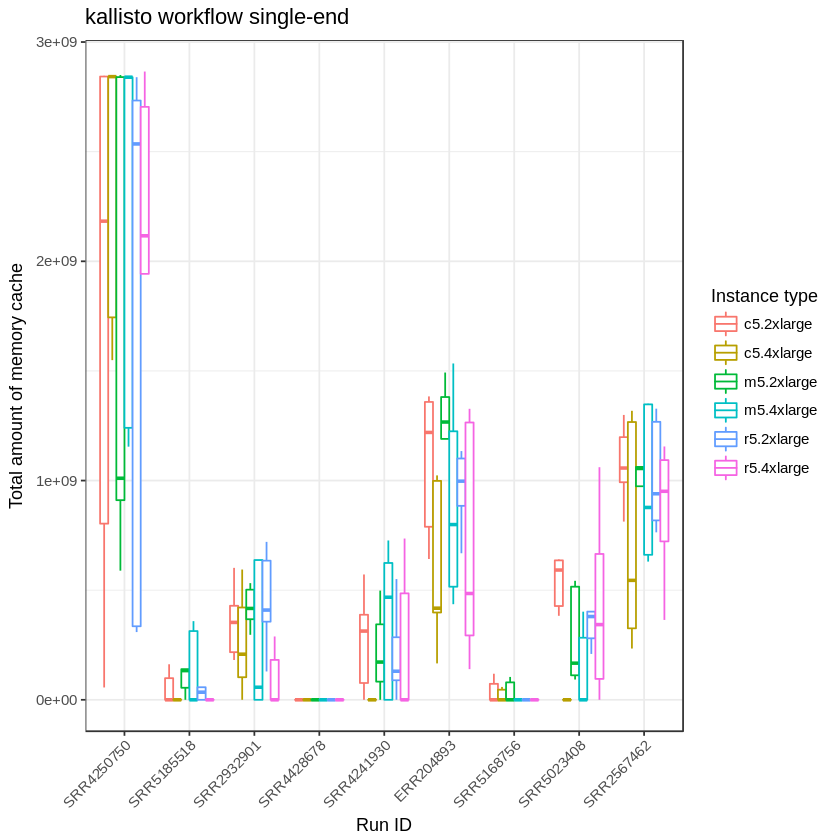

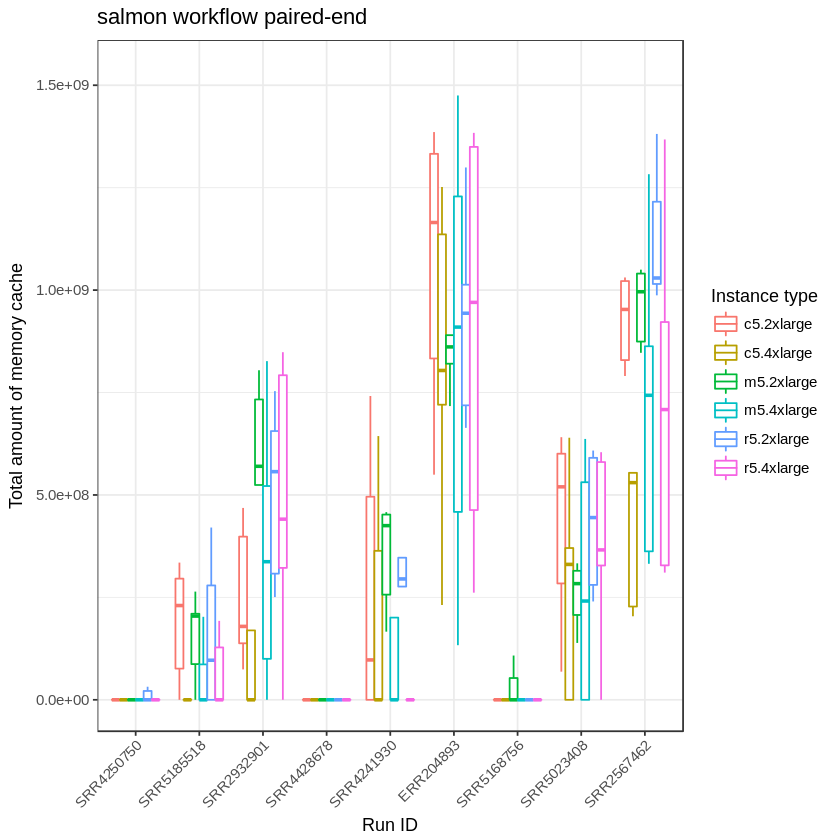

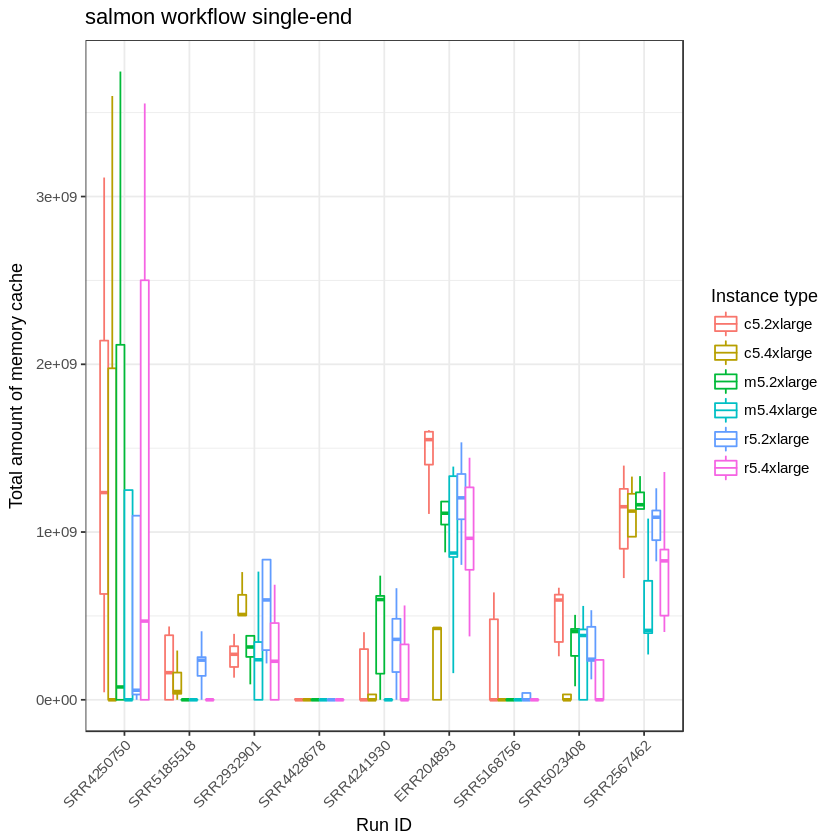

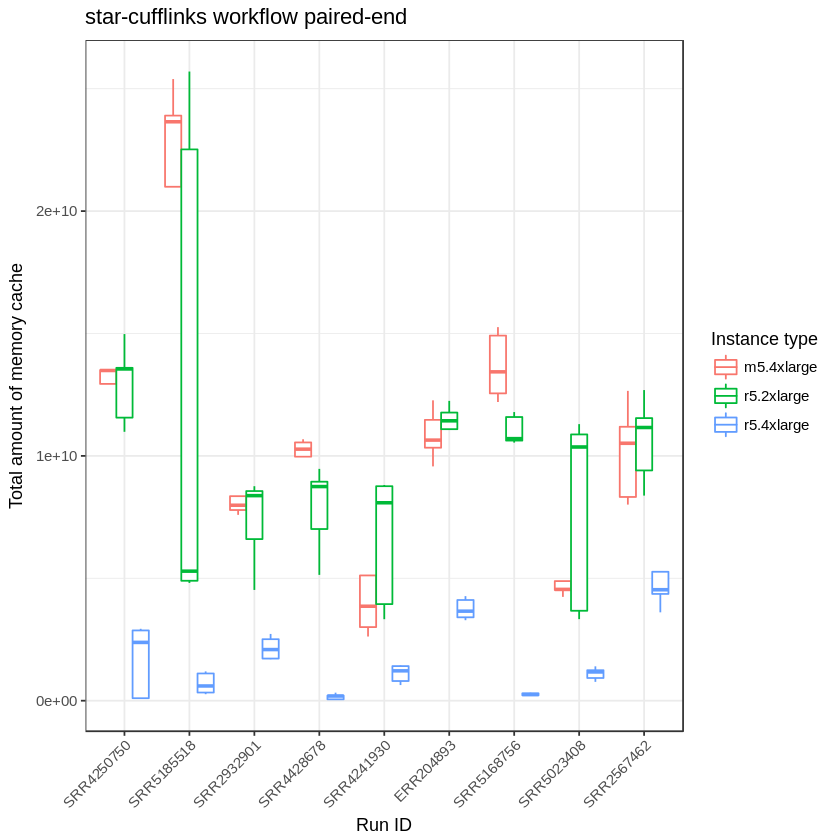

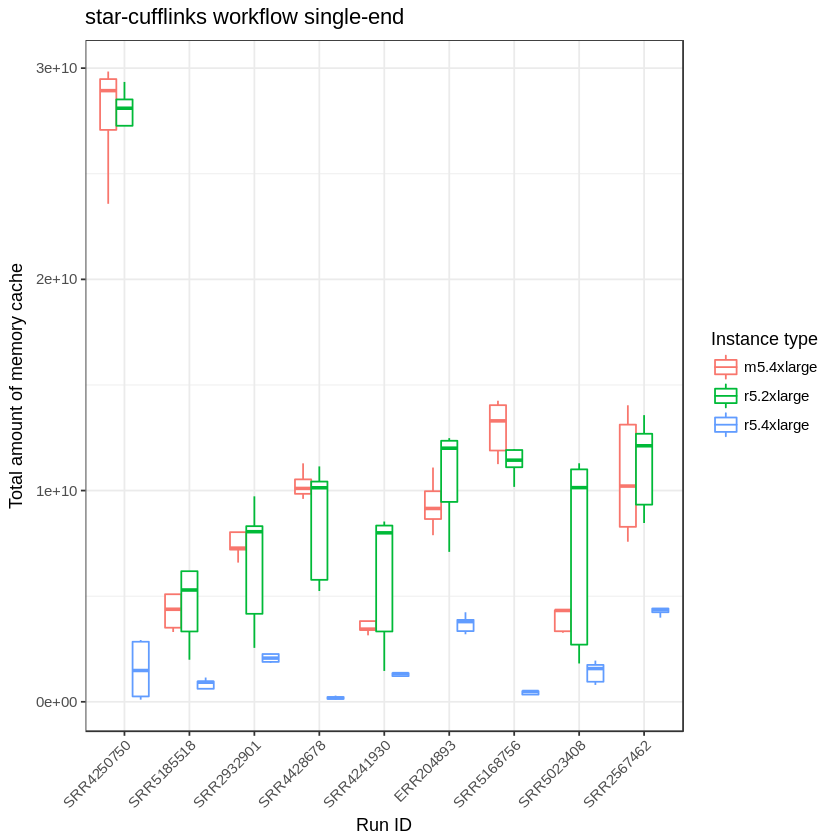

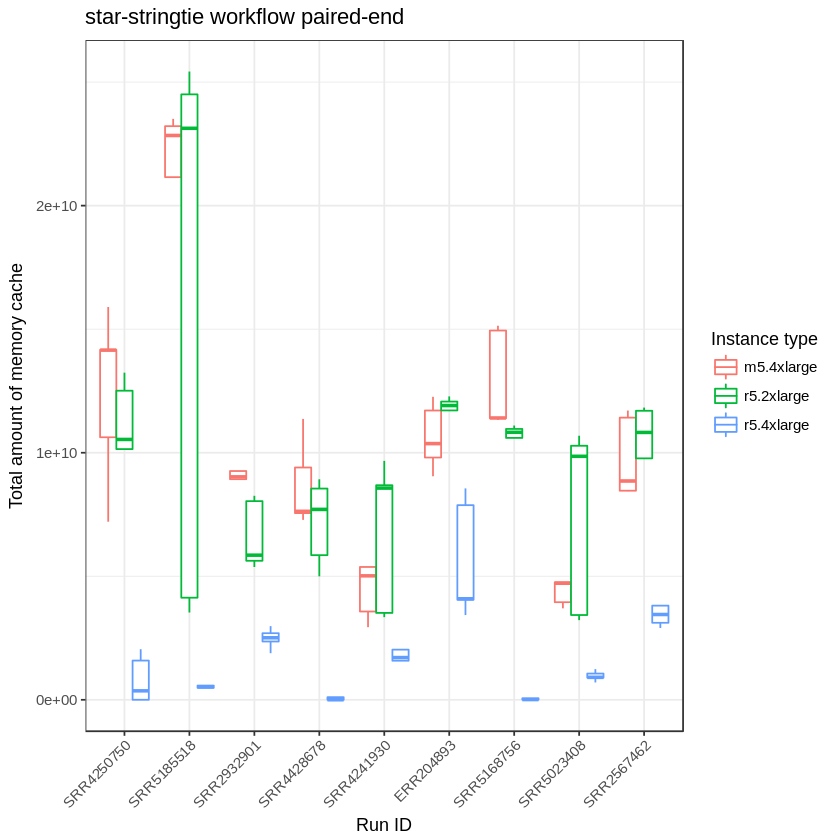

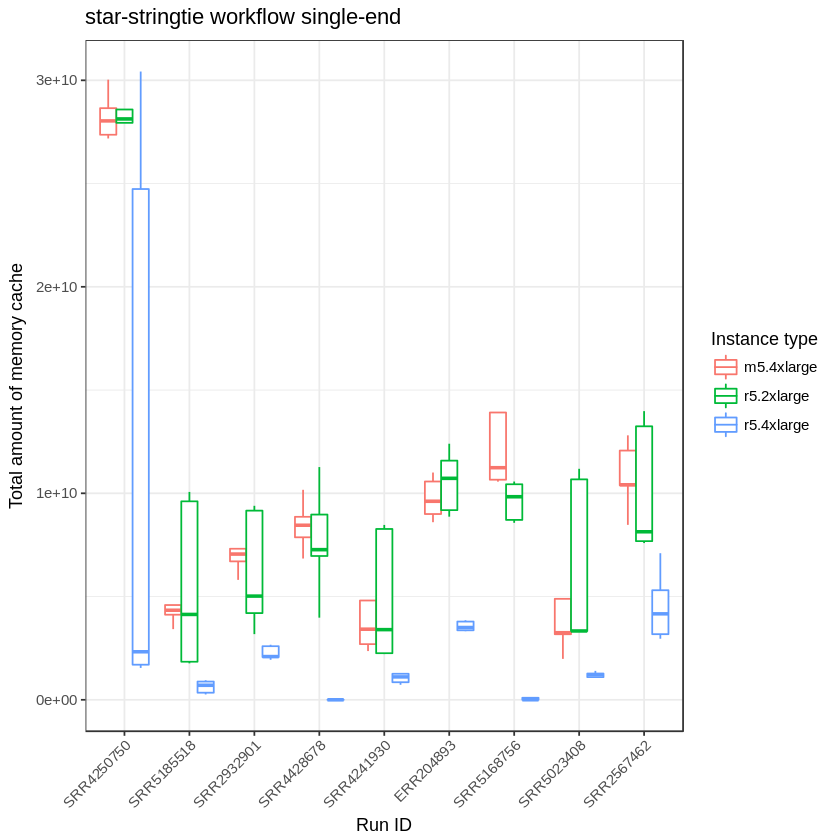

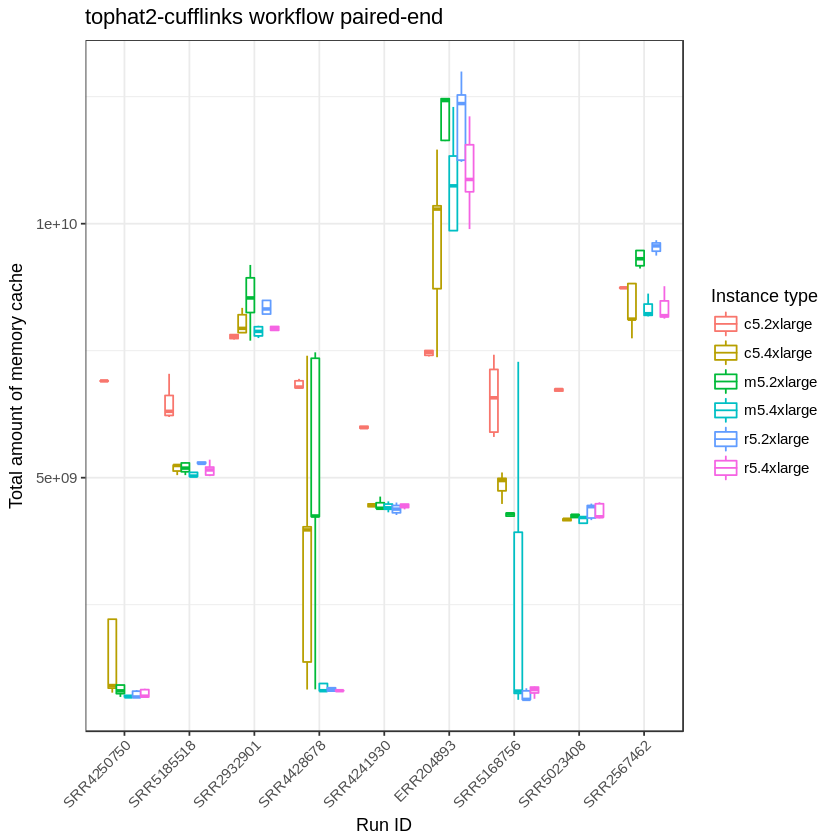

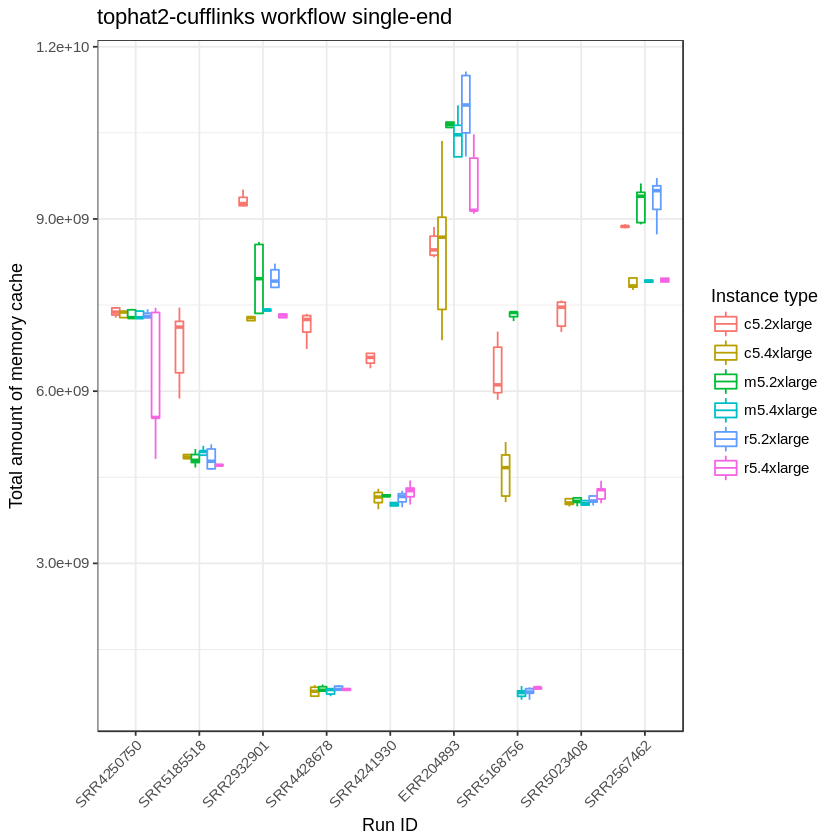

In [31]:
runs <- c("SRR4250750","SRR5185518","SRR2932901","SRR4428678","SRR4241930","ERR204893","SRR5168756","SRR5023408","SRR2567462")
workflow_name <- sort(unique(metrics$workflow_name))
for(wf_name in workflow_name) {
    d <- subset(metrics, workflow_name == wf_name)
    #d <- subset(d, processing_duration < summary(d$processing_duration)[5]*1.5)
    
    p <- ggplot(d, aes(x=factor(run_id, levels=runs, ordered=TRUE), y=cache, colour=factor(instance_type)))
    p <- p + geom_boxplot(outlier.shape=NA)
    p <- p + theme_bw() + theme(axis.text.x = element_text(angle = 45, hjust = 1))
    p <- p + labs(title=workflowName2PlotTitle(wf_name), x="Run ID", y="Total amount of memory cache", colour="Instance type")
    
    print(p)
}

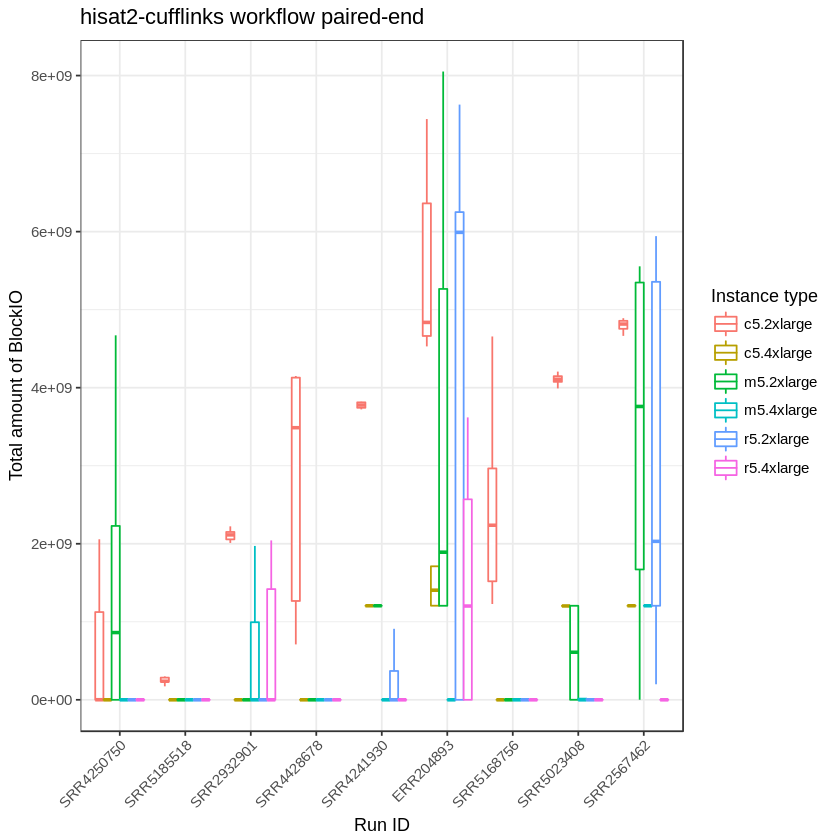

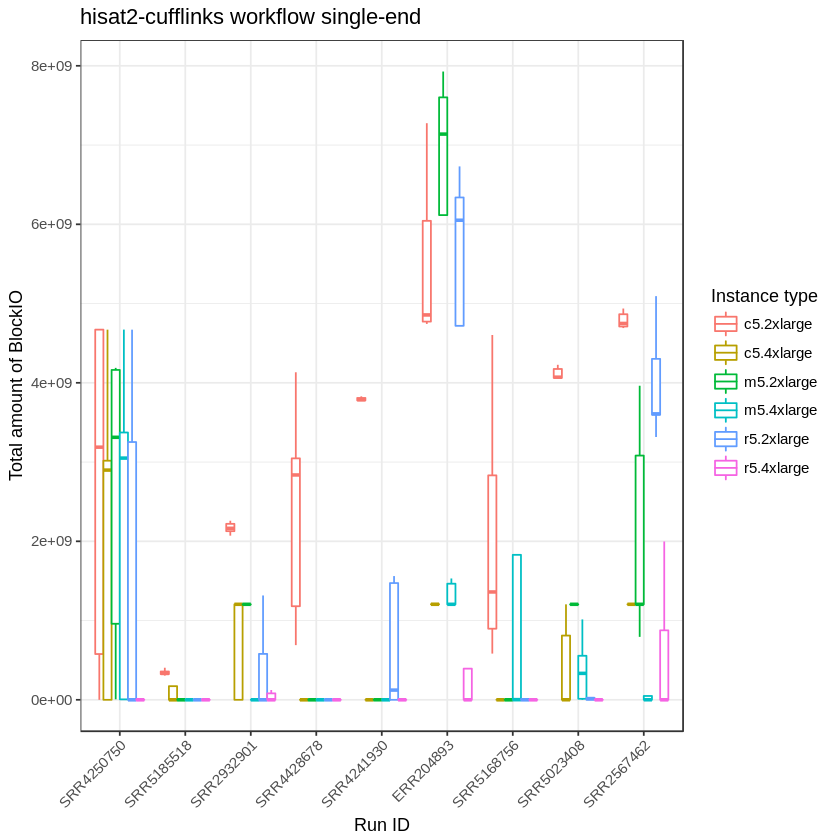

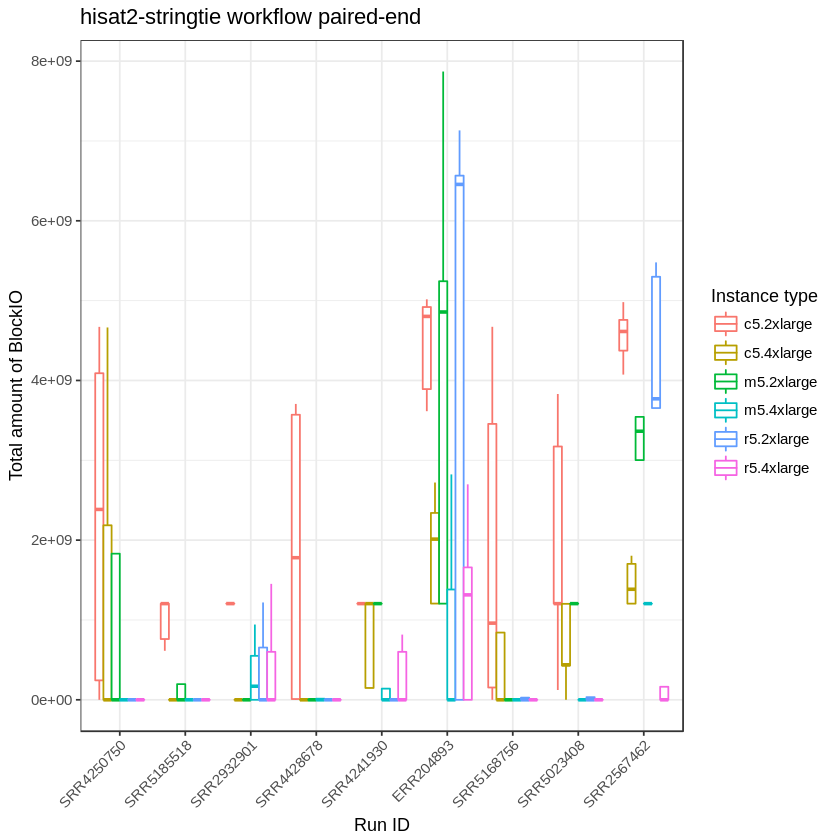

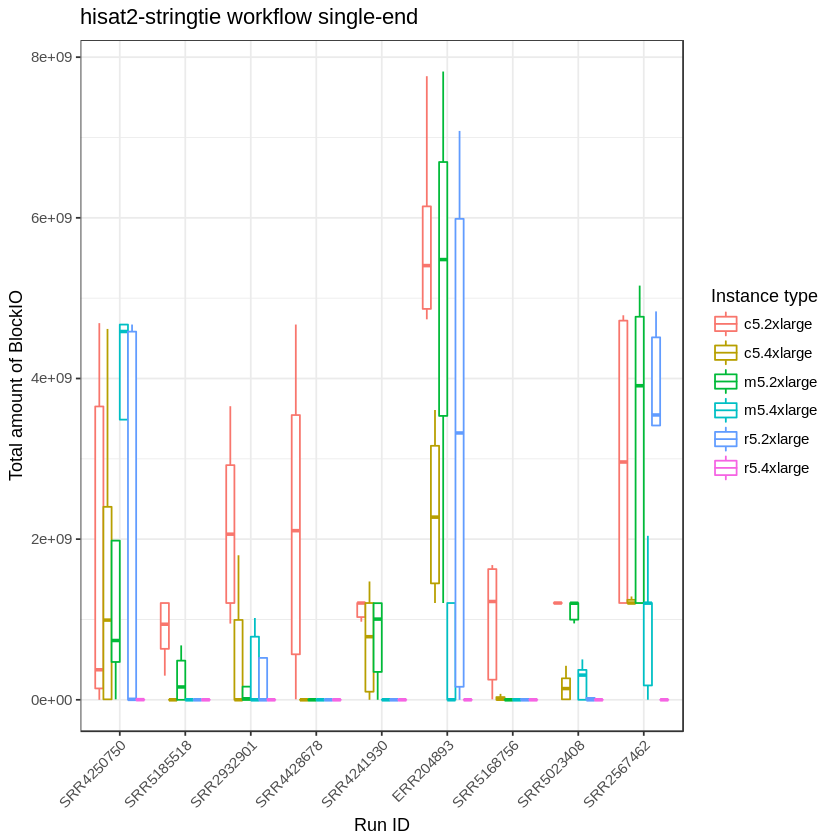

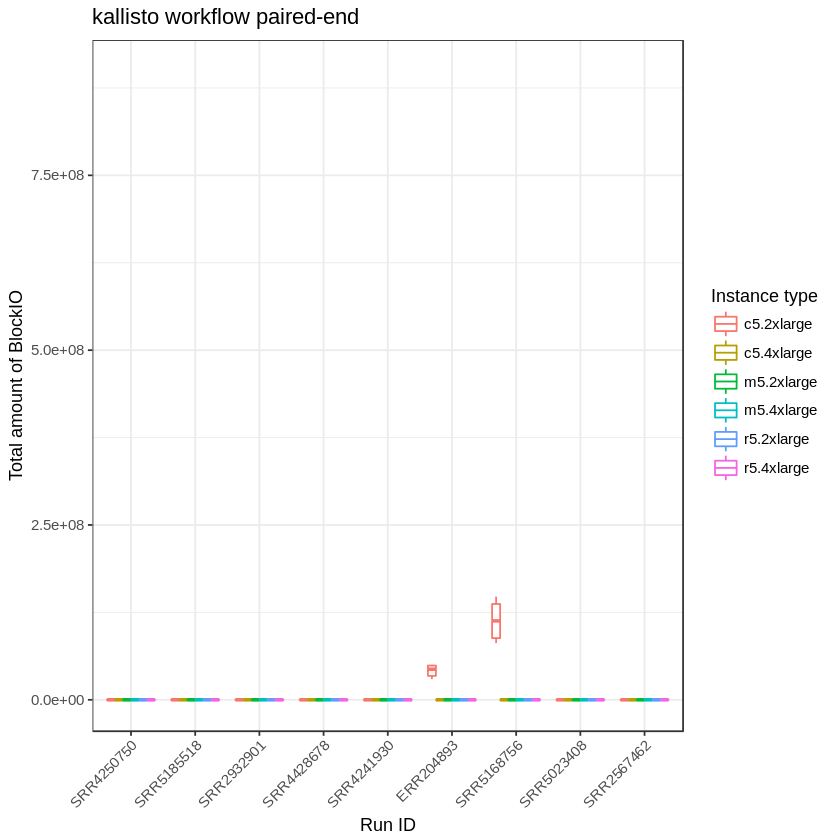

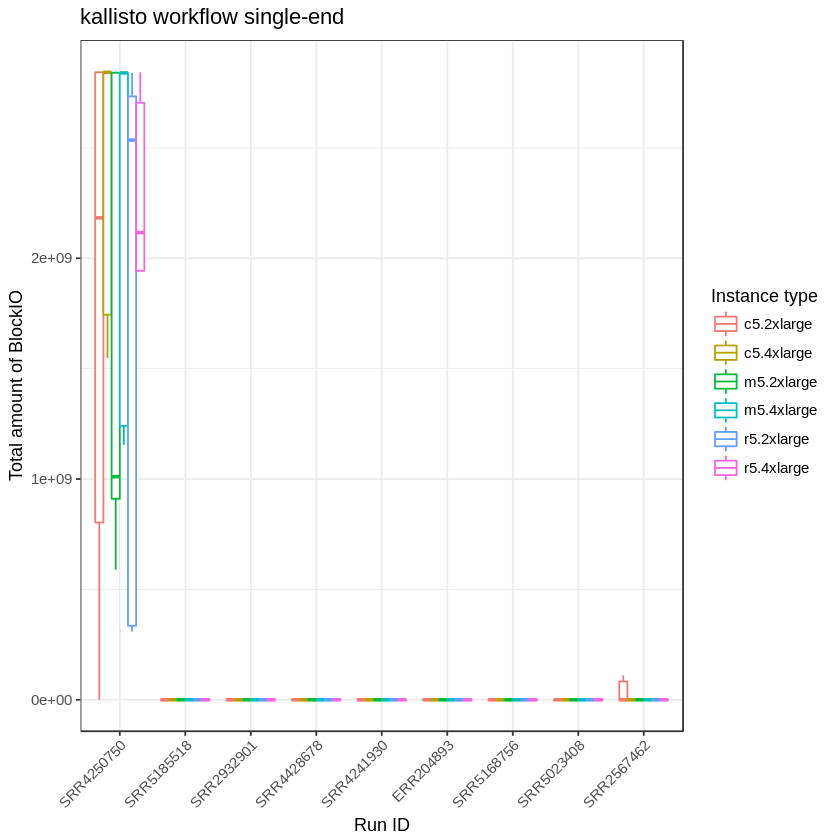

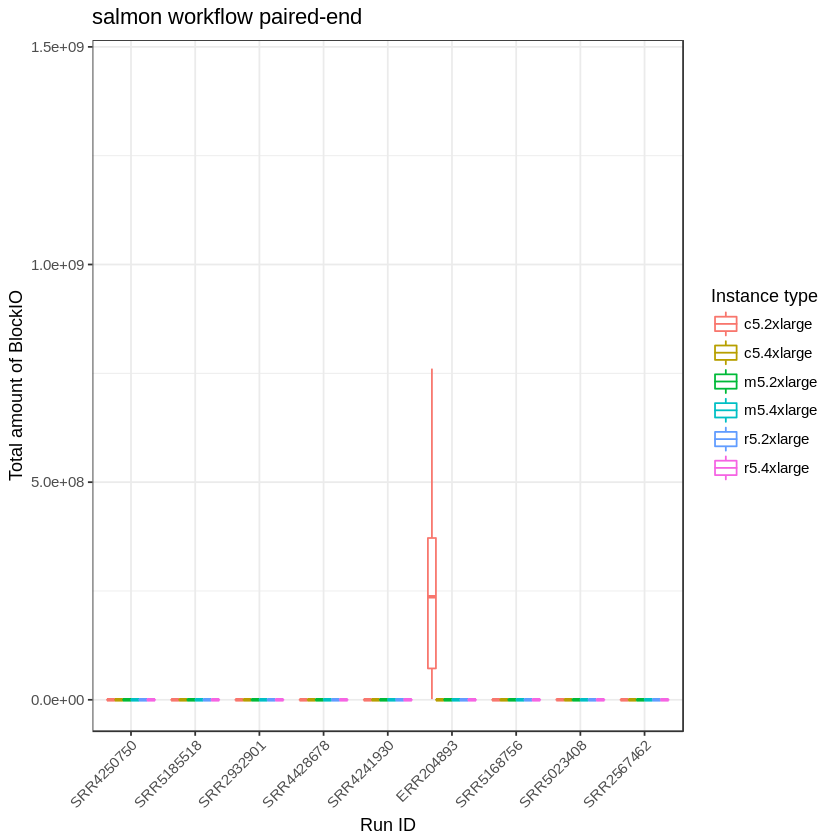

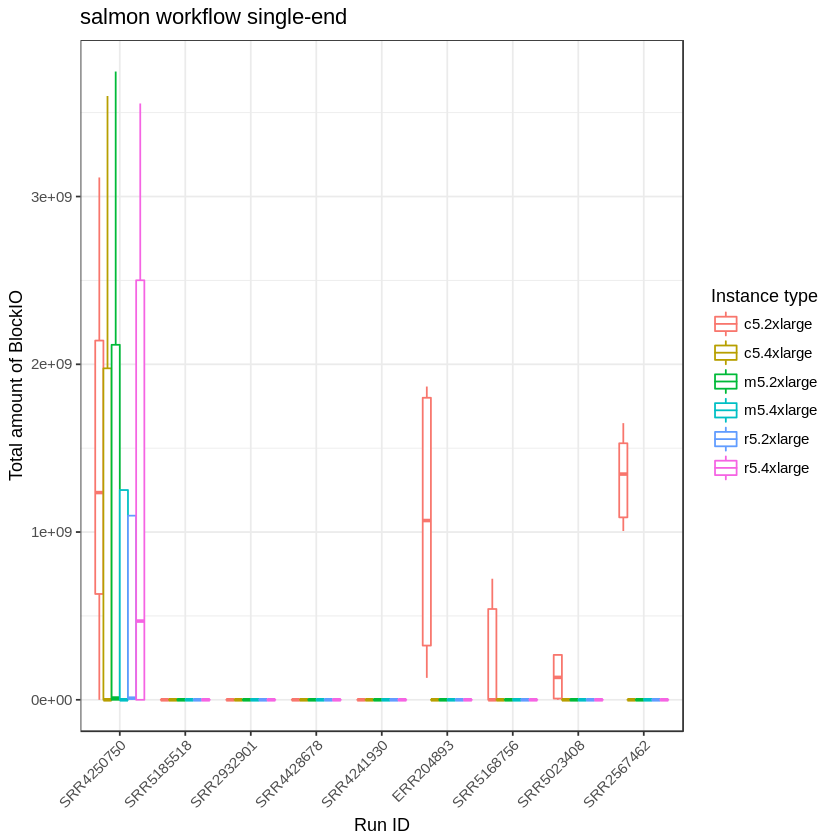

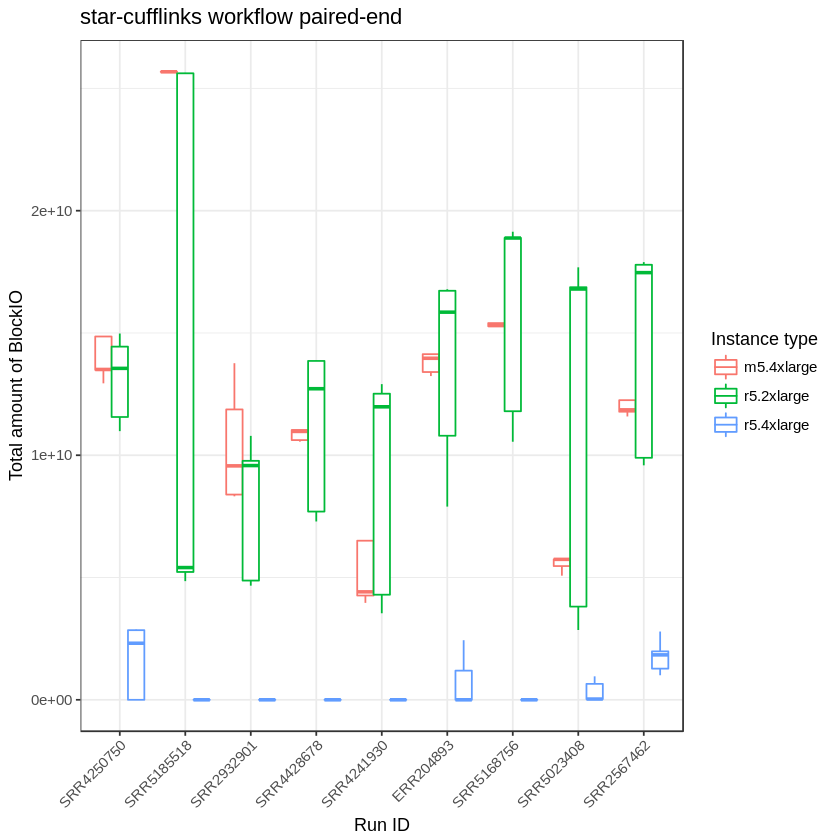

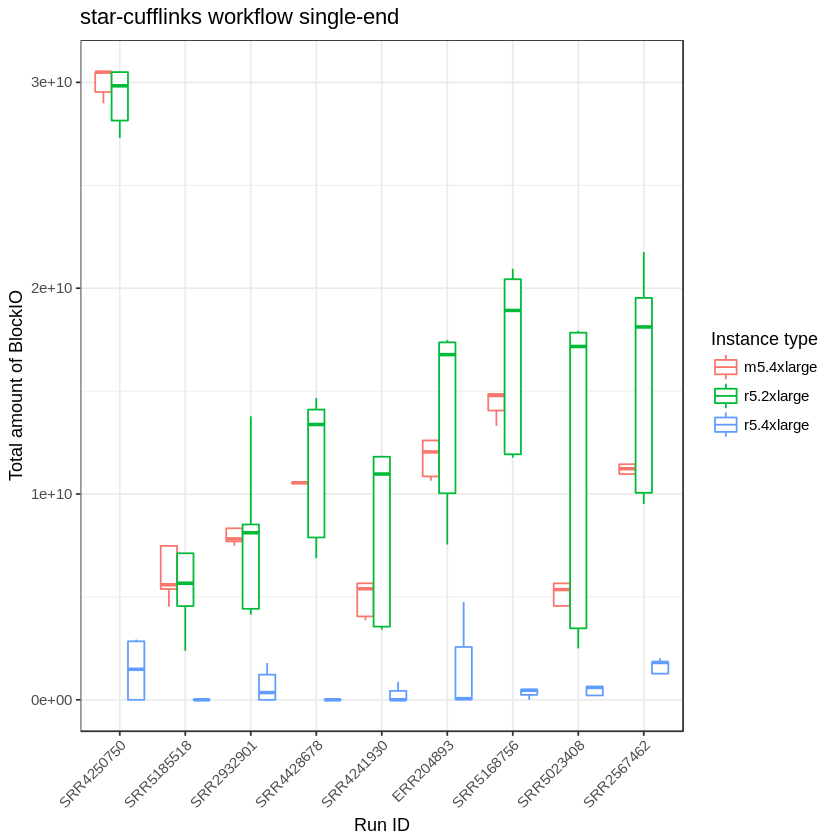

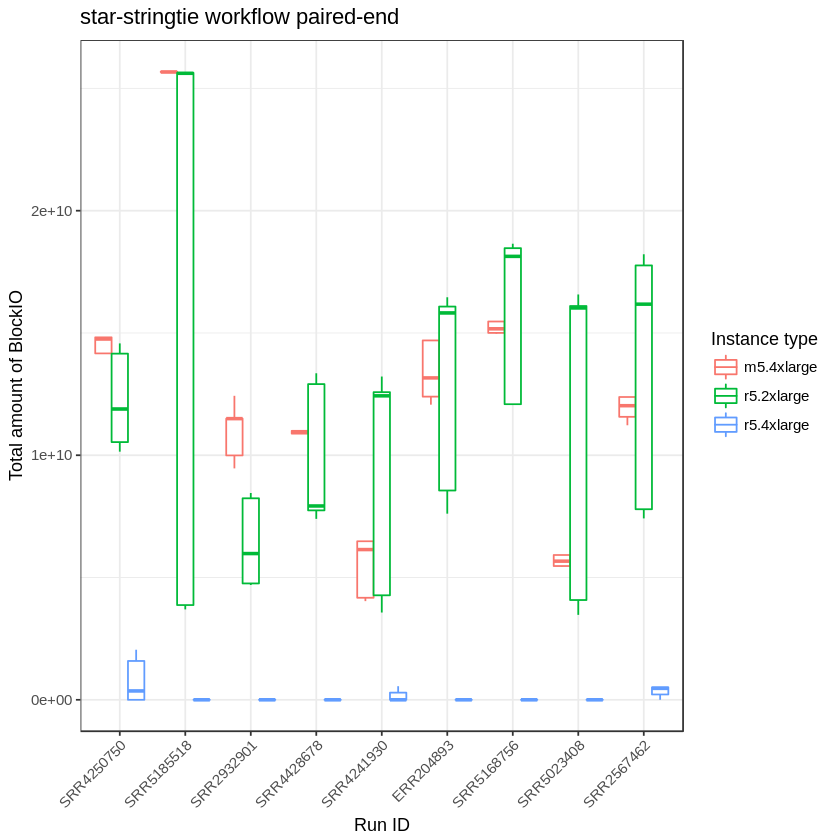

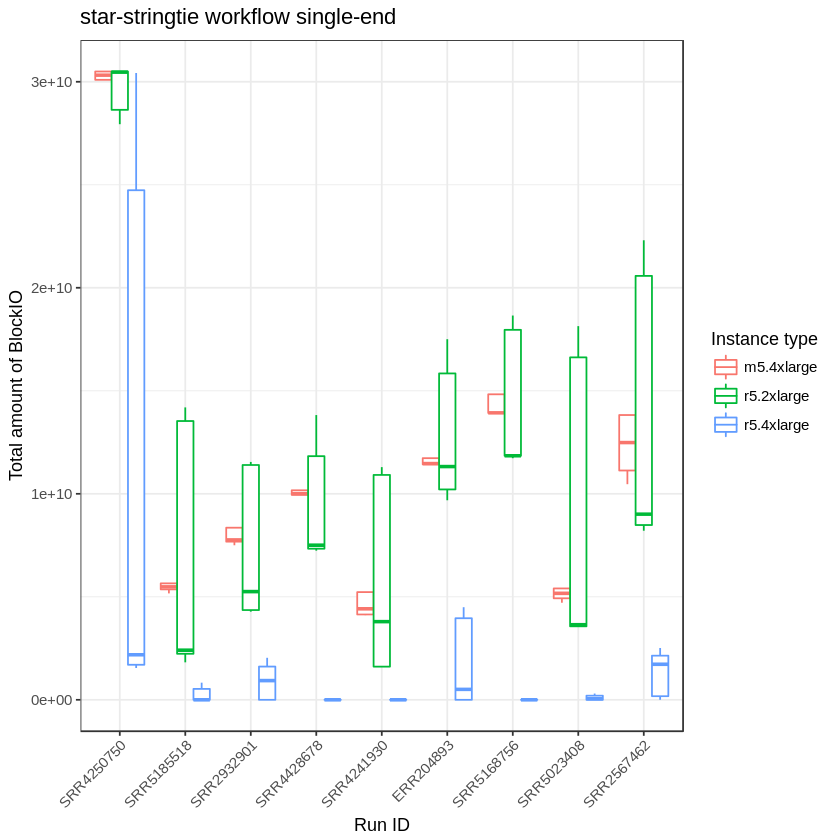

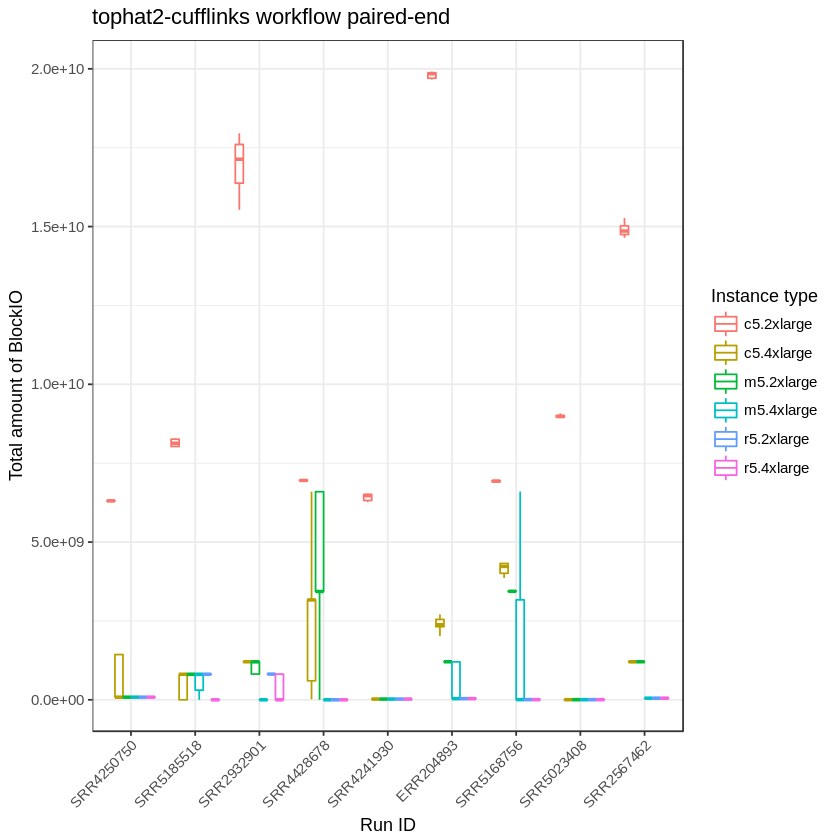

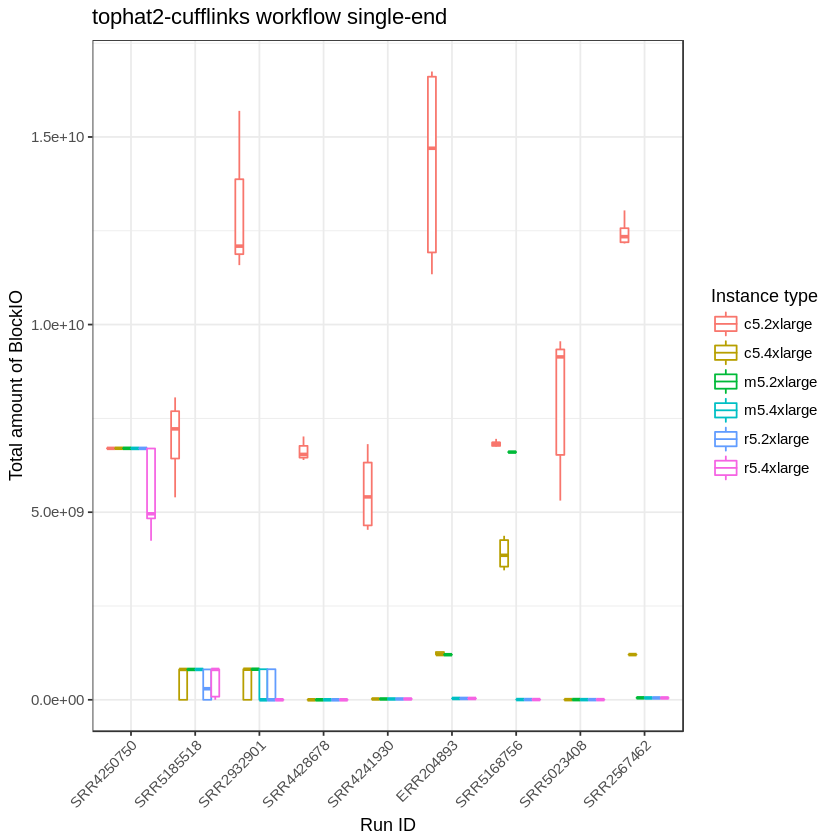

In [32]:
runs <- c("SRR4250750","SRR5185518","SRR2932901","SRR4428678","SRR4241930","ERR204893","SRR5168756","SRR5023408","SRR2567462")
workflow_name <- sort(unique(metrics$workflow_name))
for(wf_name in workflow_name) {
    d <- subset(metrics, workflow_name == wf_name)
    #d <- subset(d, processing_duration < summary(d$processing_duration)[5]*1.5)
    
    p <- ggplot(d, aes(x=factor(run_id, levels=runs, ordered=TRUE), y=blkio, colour=factor(instance_type)))
    p <- p + geom_boxplot(outlier.shape=NA)
    p <- p + theme_bw() + theme(axis.text.x = element_text(angle = 45, hjust = 1))
    p <- p + labs(title=workflowName2PlotTitle(wf_name), x="Run ID", y="Total amount of BlockIO", colour="Instance type")
    
    print(p)
}

## Boxplot for runtime metrics distribution per sample

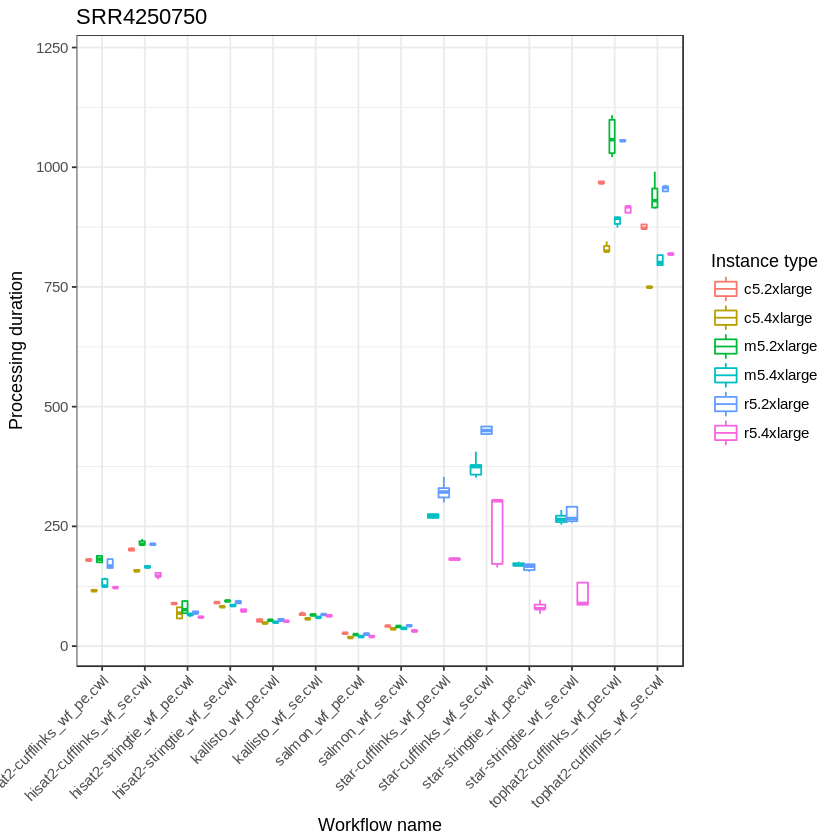

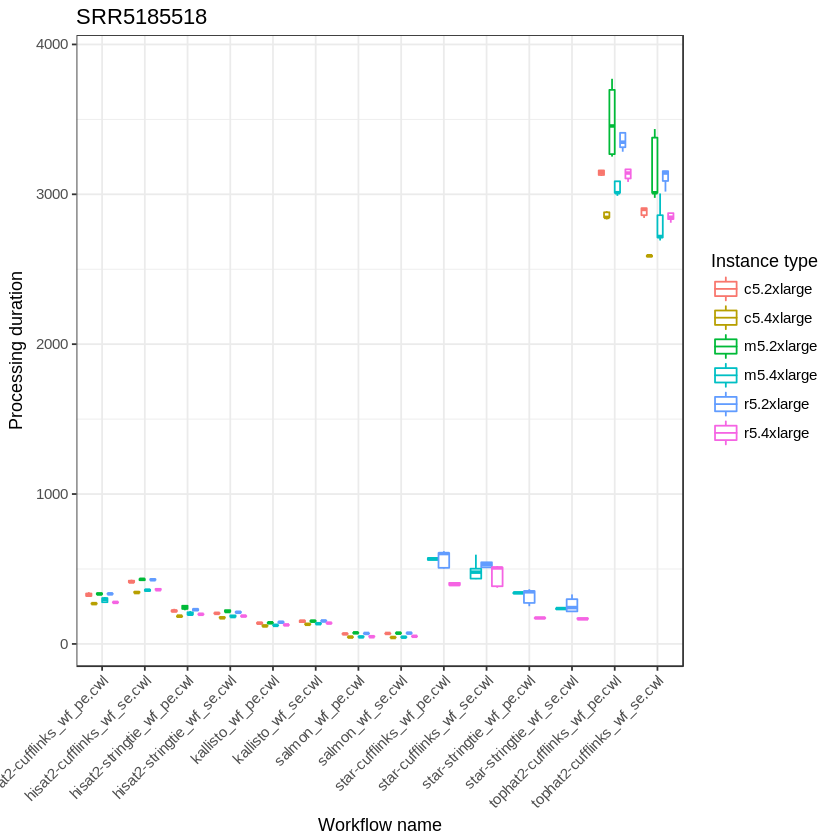

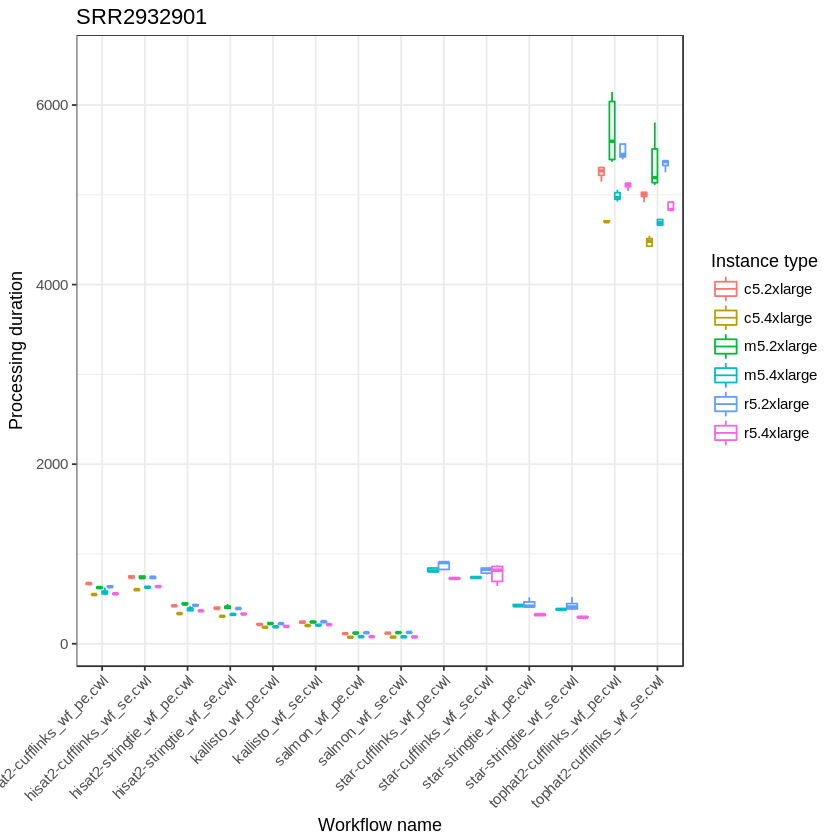

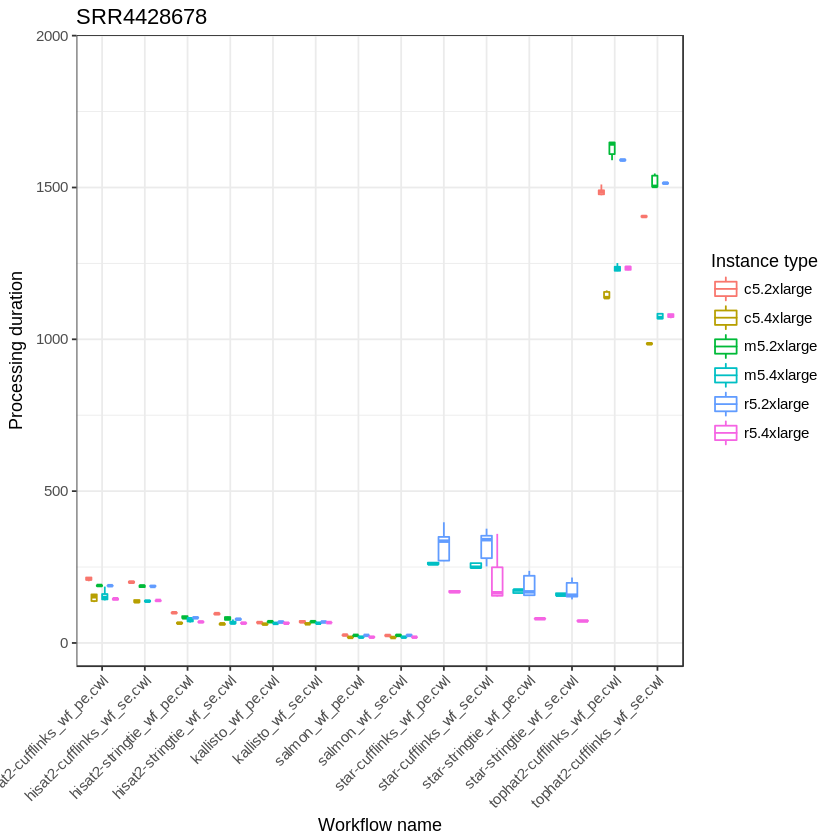

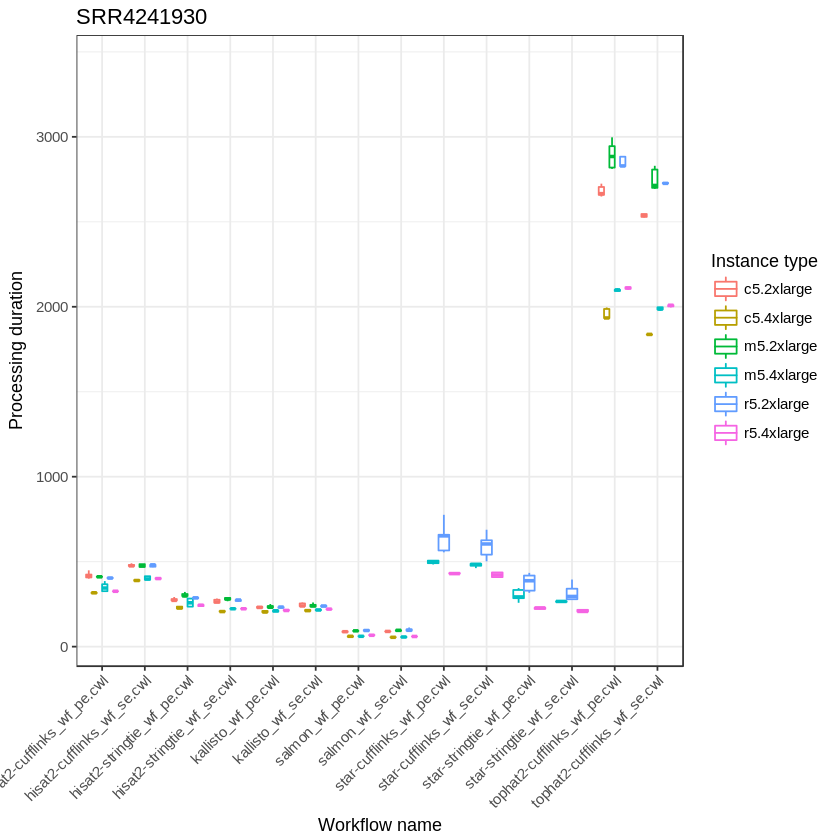

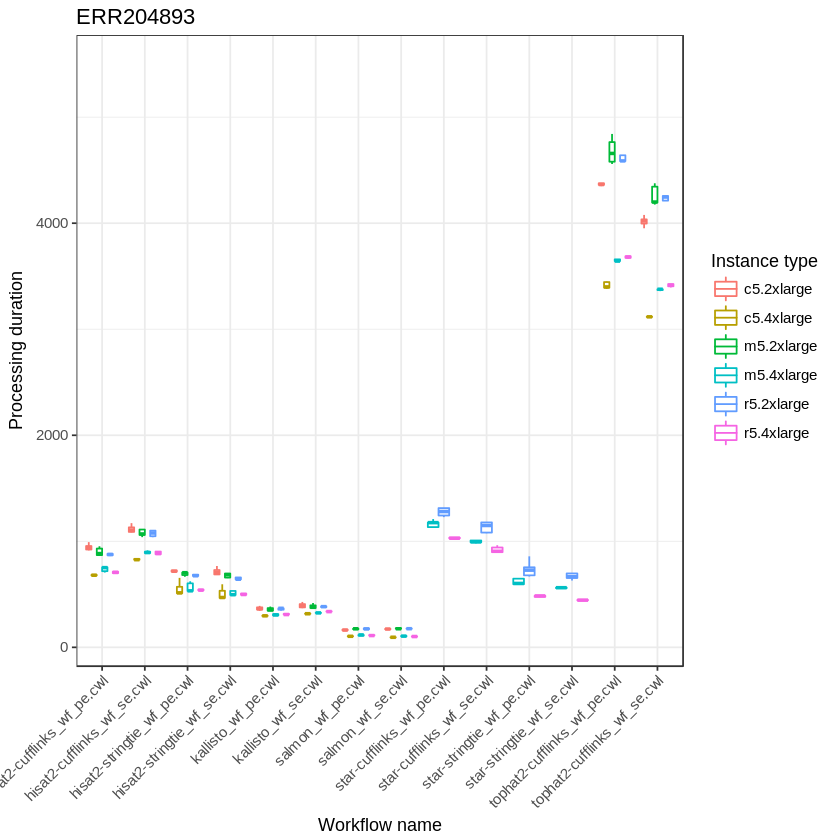

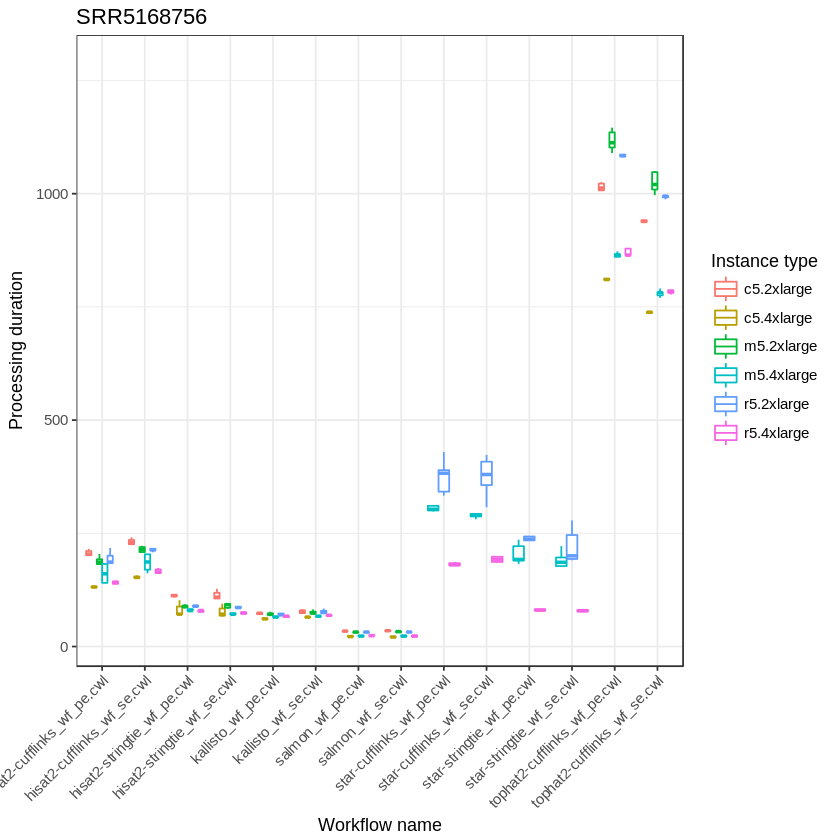

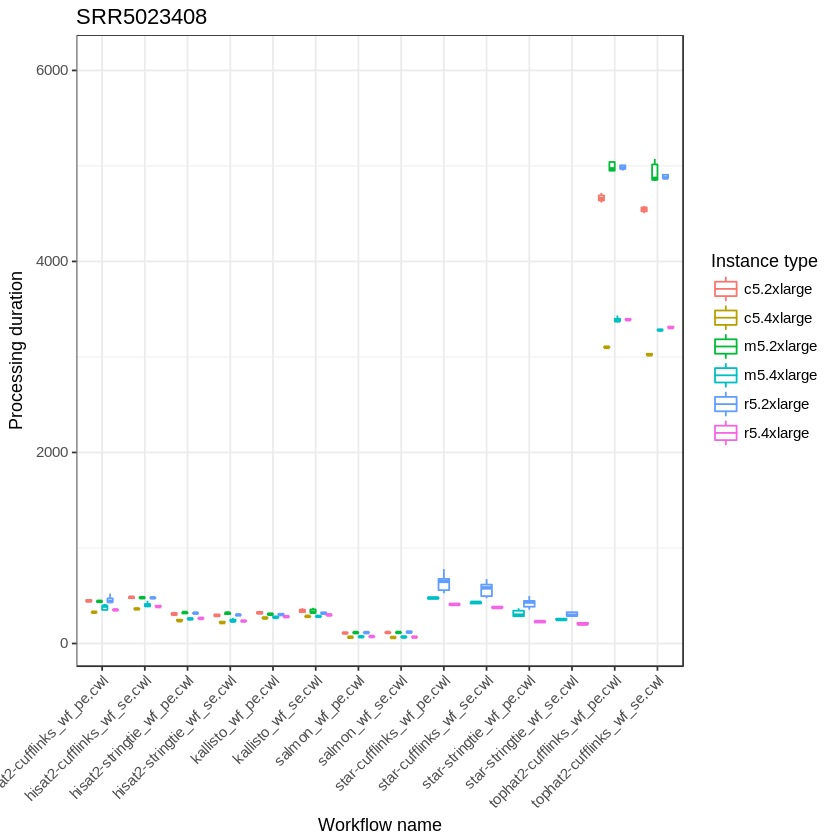

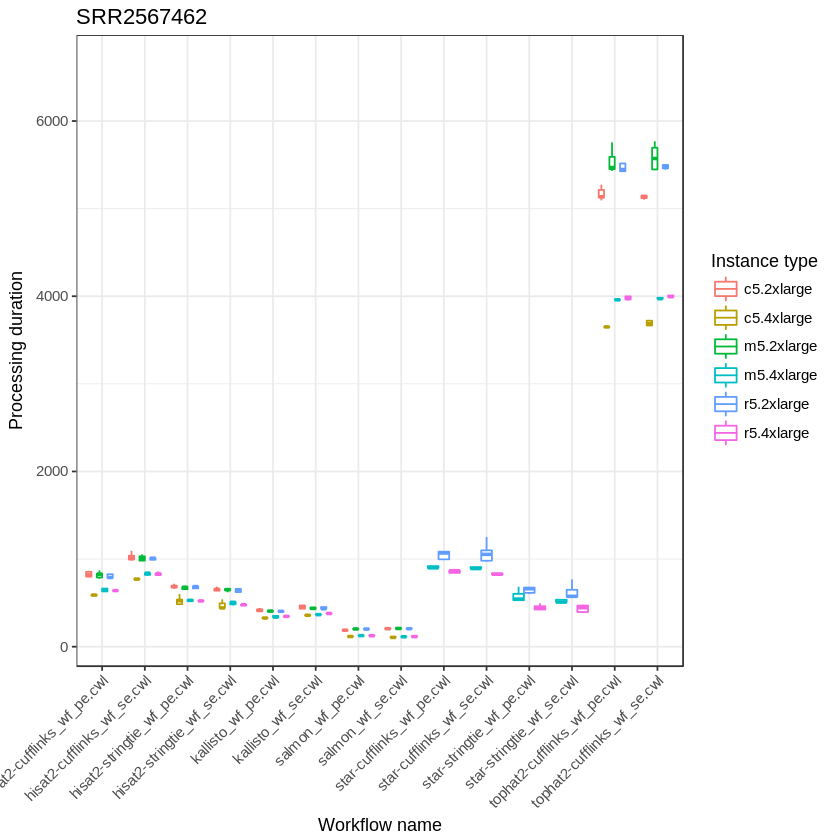

In [44]:
runs <- c("SRR4250750","SRR5185518","SRR2932901","SRR4428678","SRR4241930","ERR204893","SRR5168756","SRR5023408","SRR2567462")
workflow.name <- unique(d$workflow_name)

for (id in runs) {
    d <- subset(metrics, run_id == id)
    d <- foreach(i=1:NROW(workflow.name), .combine='rbind') %do% {
        wf.met <- subset(d, d$workflow_name == workflow.name[i])
        subset(wf.met, processing_duration < summary(wf.met$processing_duration)[5]*1.5)
    }

    p <- ggplot(d, aes(x=workflow_name, y=processing_duration, colour=factor(instance_type)))
    p <- p + geom_boxplot(outlier.shape=NA)
    p <- p + theme_bw() + theme(axis.text.x = element_text(angle = 45, hjust = 1))
    p <- p + labs(title=id, x="Workflow name", y="Processing duration", colour="Instance type")
    
    print(p)
}